# Summary
> This notebook forces on source #2, but also tries out using objects/class(es) and outputting a gallery of LCs and color-mag diagrams for a bunch of sources.
- The known orbital period of the system is 84 days. There is dramatic super-orbital modulation (covering 1.1 magnitudes in I mag), which repeats (two peaks, two troughs within the ~7000 days), but it is not symmetrical. The automatic zoom-in (in Sec. 1) show the small-amplitude peaks suggestive of the orbital period. 
- There is nothing much to take away from the autopd function. The best periods on chunks of the LC are clustered between 80 and 100 days.
- There is a strong correlation between I and V-I (my norm is to flip the I mag axis so the appearance of positive correlation in the plot is indicative of redder when brighter).
- I do further periodogram/phase-folding searches. I focus on using chunks of the LC that do not include large (here: >20 day, but argument can be changed) sampling gaps. In particular, the finddense function also identifies the chunk with the most points. In this chunk, the best period is 6.79 days. The multiphase function can output both a periodogram and phase-folded LCs using the peaks in the periodogram above some threshold (default 20 sigma). The 6.79 day fold is compelling. Throughout the full LC, there are suggestions of a ~6-7 day period but further statistical work would be necessary to back this up. In particular, the periodograms don't always return the same precise value, and the sampling is not always good enough to be convincing of such a period. Either way, such a periodicity is likely not important in considering the full system. Within this dense region (inds 783 to 938), the 84 day period also looks good, but the wide periodogram peak in that vicinity is at 79 days. The difference in the fold is trivial.
- I plot the LC chunks with their periodograms inset. This method could've been conducive for noticing some connection between the shape of the LC and the periodogram result, though nothing jumped out. There is variation, but most show narrow peaks at low values (5-7) as well as wide, high-powered ones around the orbital periods and often local peaks at 50+/- 10 days. The two following plots are helpful, showing best period vs. time (and then the second also includes light grey points showing the second best period) with the power of the peaks shown by color. You can see clustering around the orbital period and around 6.8 days. All the remaining points have lower powers and may be factors of the orbital period (e.g. ~42 days). 
- In general, the difficulty with this source comes from the fact that the flares/indications of orbital period have amplitudes that are not much greater to the other variability. As such, there are often other similar-looking features (shown in Sec. 3).
- In the final part of Sec. 2 I see if detrending helps any of the searching (not really as far as I can tell). With the chunks of the LC, I do both the filter windown detrending and just fit a line as another method of detrending. I do periodogram searches closer to the orbital period and phase-fold using the orbital period.
- Searching with a higher max period and with more of the full LC gives periods of 300-400 days. However, the value given is inconsistent and I believe it just has to do with the sampling of the LC (clusters of observations in this timeframe). This part can be checked, but I also don't notice any feautres indicating this periodicity.
- In Section 3, I use the LC itself to look for periodicity. This part can be skipped; it's quite long because small chunks have to be used to identify the 84 day flaring by-eye. The important info is summarized in Sec. 4. There is good indication of the success of the orbital period, althoguh there are sometimes comparable "flares" outside of this periodicity. **Further study of flare amplitudes is necessary**. 
- Section 4 shows the LC (in chunks for ease) in single plots, with lines spaced by 84 days. The first couple subplots illustrate the effect of propogating example errors on the first flare center and on the orbital period. The last few subplots just use lines rather than shading, since, at that point, the errors all merge togehther. 
- **The last part of the LC (last two subplots) in Sec. 4 is of particular interest and may require more investigation**. In particular, the flares in the second to last chunk have high amplitudes, and are all earlier than predicted. On the other hand, the following subplot predictions are *early*. This means that just a slight propogation of error on the 84 day perod (e.g. that it's actually lower) does not help both problems). I explore this a bit more, but not in depth quantitatively.
    - It may be worth it to fit these flares, but it may be difficult in may cases. However, I can work on developing a method of measuring the amplitude and the surrounding variability.
    - One possibility is that the orbital period periodicity is consistent and slightly higher than 84 (or that the initial center needs to be shifted but I think the former). The flares in the second to last panel may just have a different shape s.t. I'm calling the center the wrong thing. They have steep increases and then more of a normal shape, so maybe they too are actually occurring *after* the prediction, which would be consistent with the final subplot as well.
    
**I then try out using objects and classes rather than just methods. This path is a possibility and may be "better coding" but I don't see it as being significantly more efficient, especially when there are just 1-3 objects per notebook anyway. I should consider, though, if I want to be consistent with variables and then just duplicate notebooks. I'll see if anything in this notebook done in several cells is generalizable and should be added to ogle.py**

**Galleries of ~30 of the sources can be found at the end of the notebook, in groups of ten. They just show the I band LC for each next to its color-mag diagram. Most are of course redder when brighter, but there will definitely be more interesting features to analyze in other diagrams. As patterns emerge on that end, I can develop more funtions for the color-mag analysis.**

# Outline
> Source 2
> - 0: Running To-Dos
> - 1: Sequence of Three Auto Functions that Inform Search
> - 2: Further Periodogram Search
> - 3: Working Directly With Light Curves
> - 4: Final LC Chunks With Lines Spaced by 84 days --> Completely Effective?

> Other
> - 5: Objects/Classes
> - 6: Gallery of a Bunch of Sources (I band LC and color-mag plot)

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
# load in table with source numbers, orbital periods, and file paths
cross = Table.read('sourcefiles.csv')

In [3]:
#dictionary to more easily go from source number to orbital period
orb_dict = dict(zip(np.array(cross['src_n']),np.array(cross['Porb']))) 
#example: gives orbital period in days for src 2
orb_dict[2]

84.0

In [4]:
#ra and dec
ra_dict = dict(zip(np.array(cross['src_n']),np.array(cross['RA_OGLE']))) 
dec_dict = dict(zip(np.array(cross['src_n']),np.array(cross['DEC_OGLE']))) 

# 0: Running To-Dos
- further investigate precision in 84 day period
    - flare-fitting, amplitudes
    - correlation to longer-term trend? changes in other variability?
- any flares in V band?

# 1: Sequence of Three Auto Functions that Inform Further Search

orbital period: 84.0


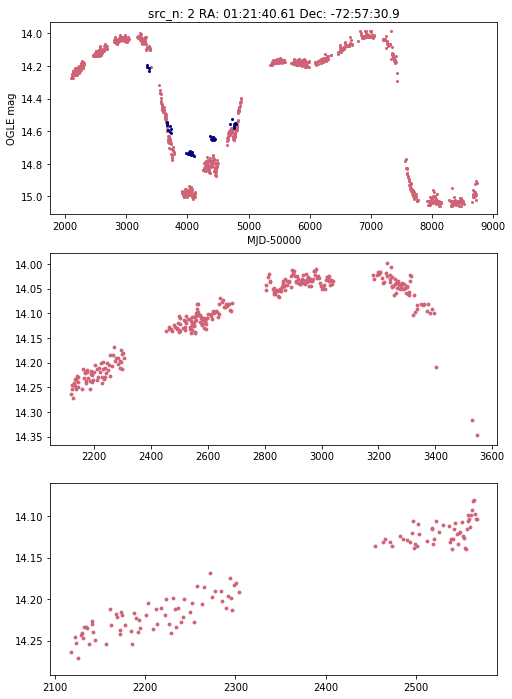

In [5]:
#load in lightcurves and plot three scales
reload(o)
ilist2,vlist2 = o.getIV(2,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband2,vband2 = vstack(ilist2),vstack(vlist2)

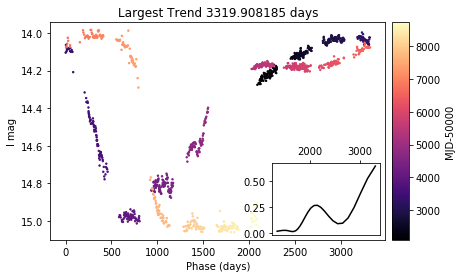

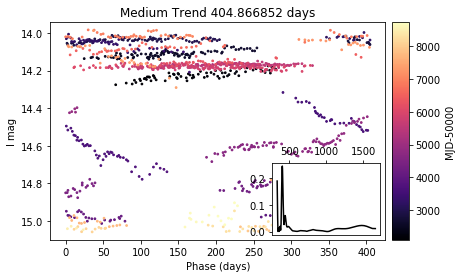

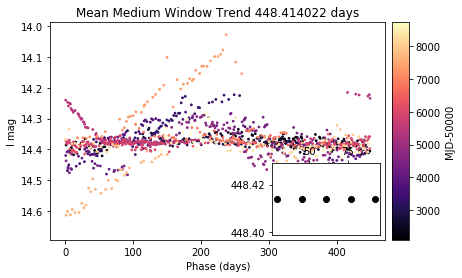

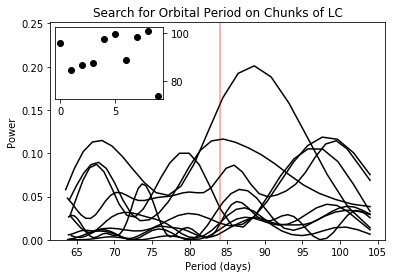

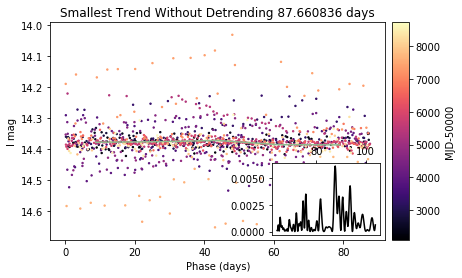

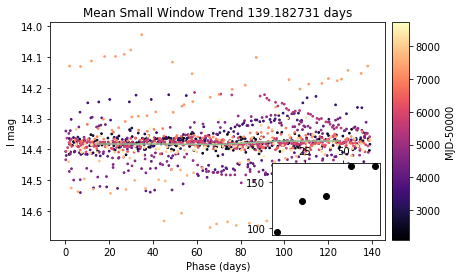

In [6]:
#automatic periodograms
o.autopd(iband2,orb_dict[2],plotpd=True,plotphase=True,printall=False,ctime=True,orb_bounds=(20,20),cutlc=True,numcuts=10,plotdet=True,pbins=5,saveall=False,srcnum=2)

example where this function isn't super helpful, but worth the search
- see other quick periodogram options below

I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401


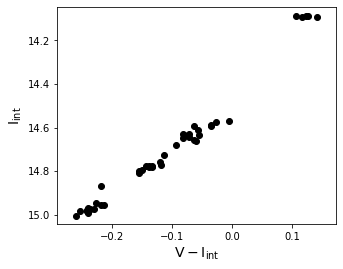

In [7]:
#V-I: positive correlation means redder when brighter
o.colormag(iband2,vband2)

I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401


(0.09, 0.16)

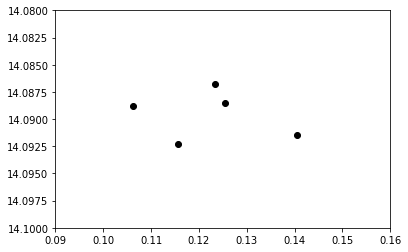

In [8]:
#zooming in on top region
i_int = o.colormag(iband2,vband2,plot=False)
plt.scatter(vband2['V mag']-i_int,i_int,color='black')
plt.ylim(14.1,14.08)
plt.xlim(.09,.16)

# 2: Further Periodogram Search
- these can be generalized into functions in ogle module

## search for lower periods using dense region

start ind: 783, end ind: 938


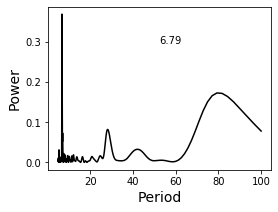

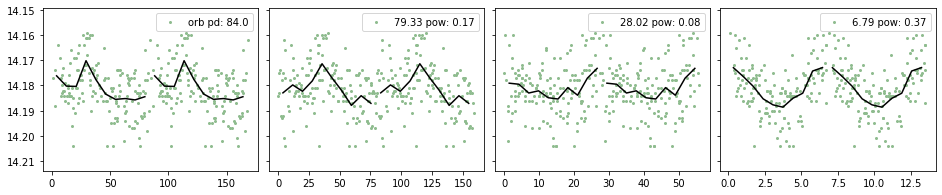

In [9]:
df,pks = o.multiphase(iband2,orb=orb_dict[2],sigma=20,plotpd=True)

In [10]:
#find dense regions -- can search in each of these
reload(o)
dense, mdense = o.finddense(iband2,retall=True)
dense

array([  72,  166,  259,  323,  400,  468,  559,  644,  782,  783,  938,
        986,  988, 1029, 1030, 1080, 1126, 1170, 1217, 1261])

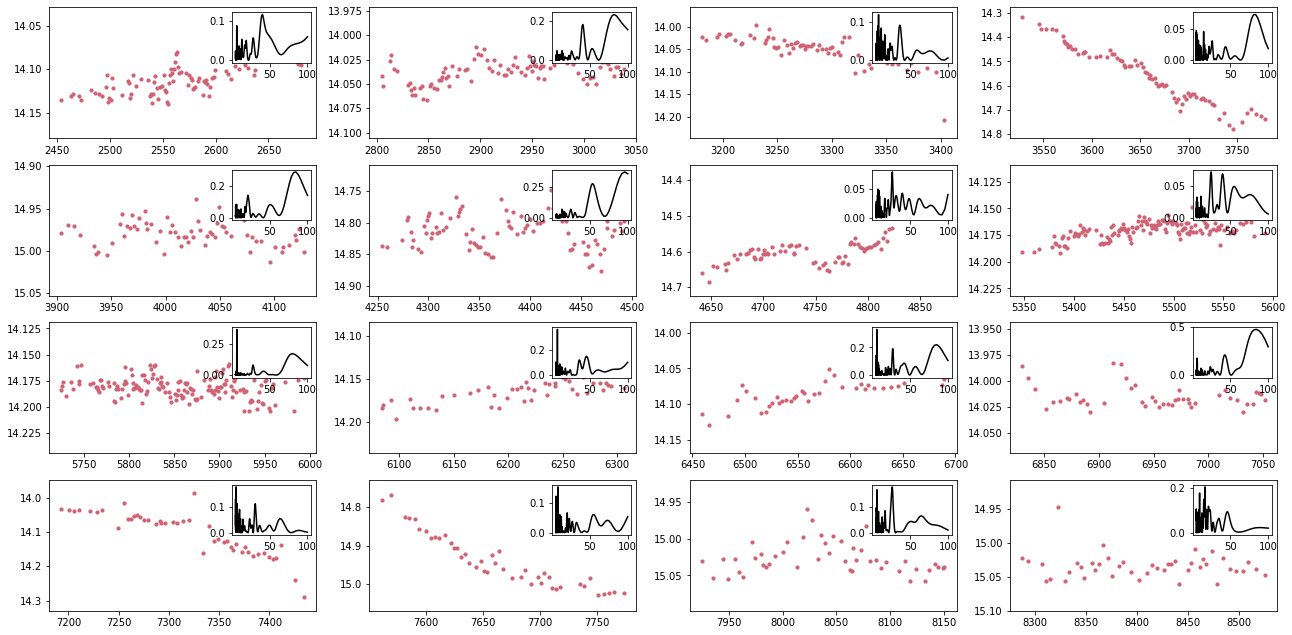

In [11]:
#plot each dense region with its periodogram
# reload(o)
figsize=(22,14)
fig = plt.figure(figsize=figsize)
p = 1 #separate counter to not leave blank spaces
bps = []
sbp = [] #second best period
maxpow = []
stdate = []
endate = []
for d in range(1,len(dense)):
    if dense[d]-dense[d-1]>30:
        st = dense[d-1]
        end = dense[d]
        ax = fig.add_subplot(5,4,p)
        ax.scatter(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],color=pink,s=10)
        maxi,mini = np.max(iband2['I mag'][st:end]),np.min(iband2['I mag'][st:end])
        ax.set_ylim(maxi+.04,mini-.04)
        #instet periodogram
        axins = inset_axes(ax, width=figsize[0]/20, height=figsize[1]/20,borderpad=0.5) 
        freq,power,bp = o.periodogram(iband2[st:end],maxp=100,more=True,plot=False)
        axins.plot(1/freq,power,color='black')
        p+=1
        bps.append(bp)
        maxpow.append(np.max(power))
        stdate.append(iband2['MJD-50000'][st:st+1])
        endate.append(iband2['MJD-50000'][end-1:end])
        #find second best period (returns df of period and power with descending power)
        pf = o.findpeaks(freq,power,sigma=10,distance=10,pkorder=True)
        sp = float(pf['period'][1:2])
        sbp.append(sp)#append second highest

In [12]:
stdate = np.array(stdate)
endate = np.array(endate)

Text(0.5, 0, 'Start Date (MJD-50000)')

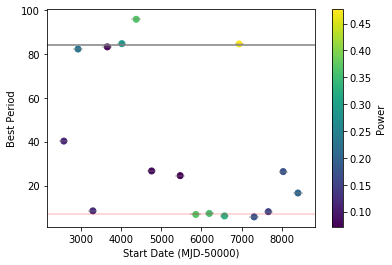

In [13]:
#point in middle of dense region
plt.scatter(stdate+(endate-stdate)/2,bps,c=maxpow)
plt.errorbar(stdate+(endate-stdate)/2,bps,xerr=(endate-stdate)/2,c='grey',alpha=0.4,linestyle='none')

plt.colorbar(label='Power')
plt.axhline(84,color='grey')
# plt.axhline(84/2,color='grey',alpha=.6)
# plt.axhline(84/3,color='grey',alpha=.4)
# plt.axhline(84/4,color='grey',alpha=.2)
plt.axhline(6.78,color='red',alpha=.2)
plt.ylabel('Best Period')
plt.xlabel('Start Date (MJD-50000)')

Text(0.5, 0, 'Start Date (MJD-50000)')

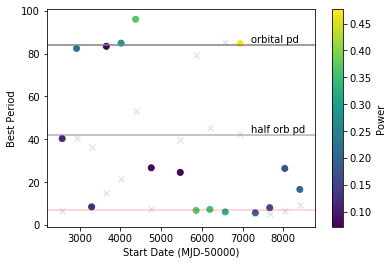

In [14]:
#version where second highest-power peak also shown in light grey
plt.scatter(stdate+(endate-stdate)/2,bps,c=maxpow)
plt.colorbar(label='Power')

plt.scatter(stdate+(endate-stdate)/2,sbp,c='grey',alpha=0.2,marker='x')

plt.axhline(84,color='grey')
plt.text(7200,85,'orbital pd')
plt.axhline(84/2,color='grey',alpha=.6)
plt.text(7200,84/2+1,'half orb pd')

# plt.axhline(84/3,color='grey',alpha=.4)
# plt.axhline(84/4,color='grey',alpha=.2)
plt.axhline(6.78,color='red',alpha=.2)
plt.ylabel('Best Period')
plt.xlabel('Start Date (MJD-50000)')

(15.1, 13.9)

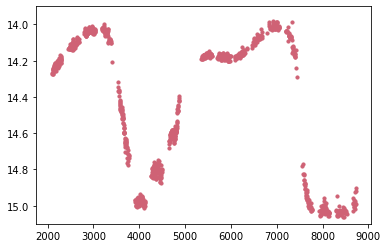

In [15]:
#just to have full lC underneath
plt.scatter(iband2['MJD-50000'],iband2['I mag'],s=10,color=pink)
plt.ylim(15.1,13.9)

start ind: 72, end ind: 166
start ind: 166, end ind: 259
start ind: 259, end ind: 323
start ind: 323, end ind: 400
start ind: 400, end ind: 468
start ind: 468, end ind: 559
start ind: 559, end ind: 644
start ind: 644, end ind: 782
start ind: 783, end ind: 938


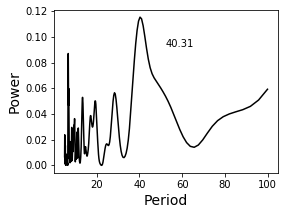

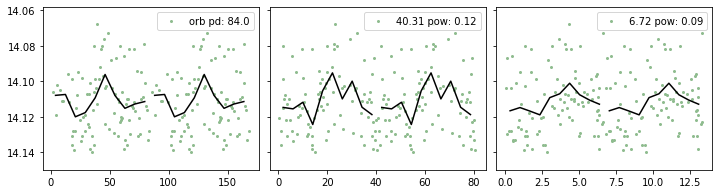

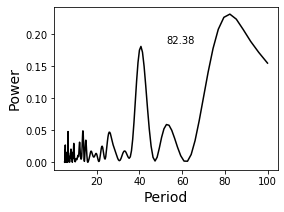

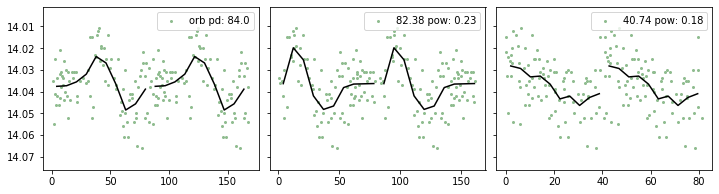

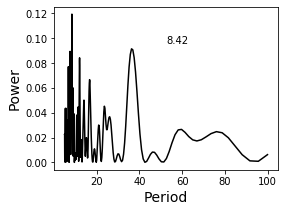

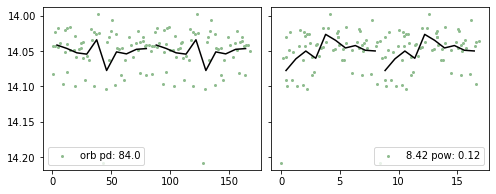

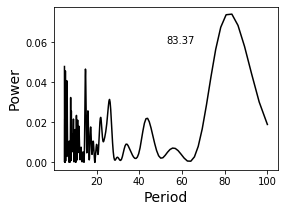

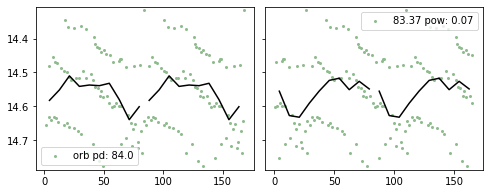

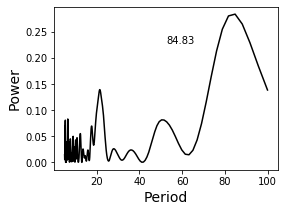

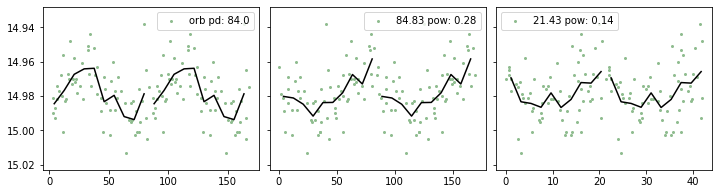

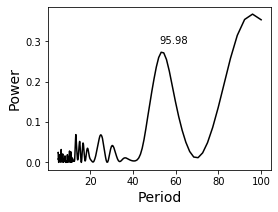

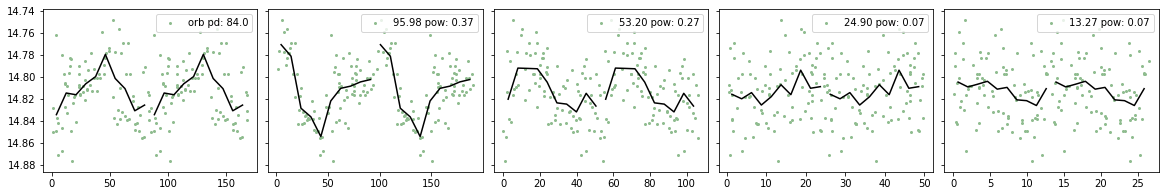

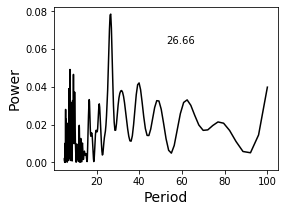

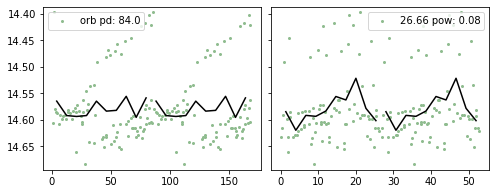

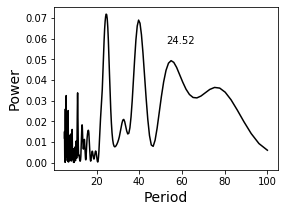

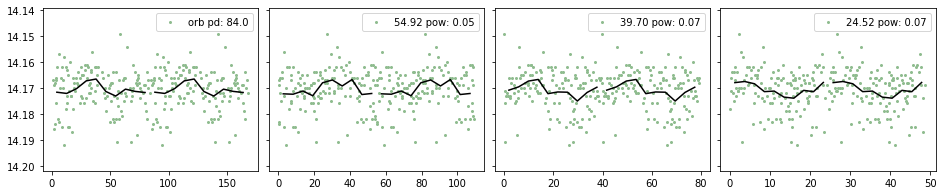

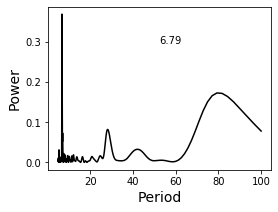

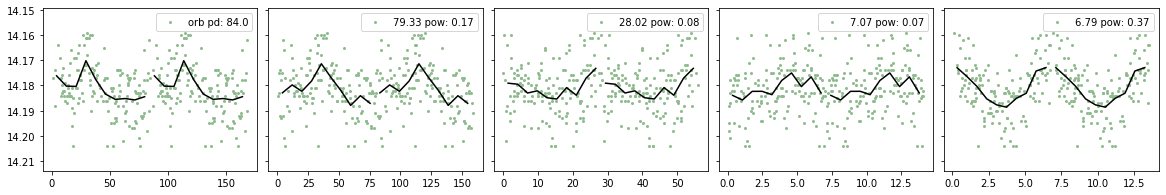

In [16]:
for d in range(1,len(dense)):
    if dense[d]-dense[d-1]>50:
        st = dense[d-1]
        end = dense[d]
        df,pks = o.multiphase(iband2,st=st,end=end,orb=orb_dict[2],sigma=20,distance=10,dense=False,plotpd=True)


#### search closer to orbital period
- each plot has periodogram from 75 to 100 days and then phase-folds each dense chunk with 84 days
- second uses detrended data instead

87.37299491214418

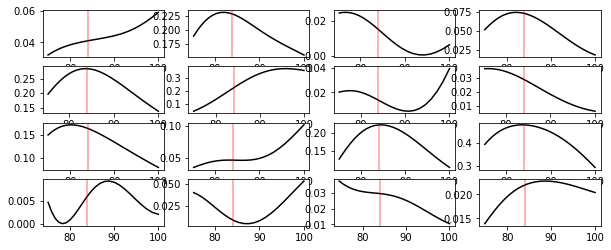

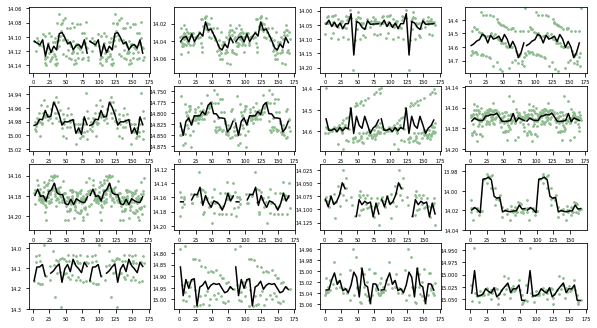

In [17]:
reload(o)
p = 1
bps = []
fig = plt.figure(figsize=(10,5))
fig2 = plt.figure(figsize=(10,7))

for d in range(1,len(dense)):
    if dense[d]-dense[d-1]>30:
        st = dense[d-1]
        end = dense[d]
        ttab = iband2[st:end]

        freq,power,bp = o.periodogram(ttab,minp=75,maxp=100,more=True,plot=False,samples=30)
        bps.append(float(bp))
        ax = fig.add_subplot(5,4,p)
        ax.plot(1/freq,power,color='black')
        ax.axvline(84,color='red',alpha=0.4)
        
        #phase-fold with 84 days
        ax = fig2.add_subplot(5,4,p)
        ax.scatter(ttab['MJD-50000']%84,ttab['I mag'],color='darkseagreen',s=3)
        ax.scatter(84+ttab['MJD-50000']%84,ttab['I mag'],color='darkseagreen',s=3)
        mid,avg = o.meanphase(ttab,84,pbins=20,det=False)
        ax.plot(mid,avg,color='black')
        ax.plot(84+mid,avg,color='black')
        maxi,mini = np.max(ttab['I mag']),np.min(ttab['I mag'])
        ax.set_ylim(maxi+.01,mini-.01)
        ax.tick_params(axis='both', labelsize=5 )   
        p+=1
np.mean(bps) #prints mean best period

## repeat dense analysis with detrending each 
- normal detrend and then fit with line

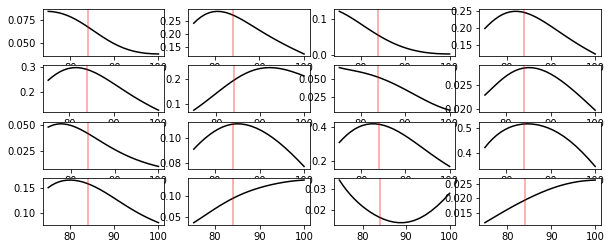

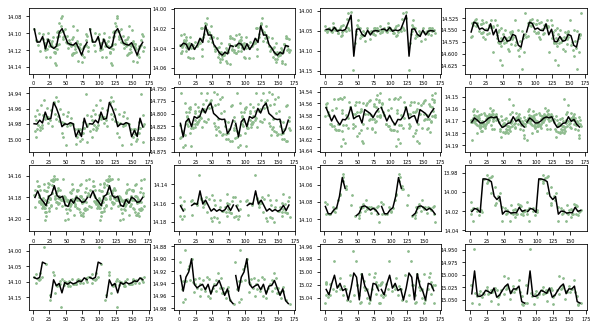

In [18]:
#periodogram on detrended data and phase fold detrended data with 84 days
fig = plt.figure(figsize=(10,5))
fig2 = plt.figure(figsize=(10,7))
p = 1
for d in range(1,len(dense)):
    if dense[d]-dense[d-1]>30:
        st = dense[d-1]
        end = dense[d]
        #temporary tab to not change detrend column in iband2
        ttab = iband2[st:end]
        o.detrend(ttab,window=31,plot=False,figsize=(4,3),size=3)
        freq,power,bp = o.periodogram(ttab,minp=75,maxp=100,more=True,det=True,plot=False,samples=30)
        bps.append(float(bp))
        ax = fig.add_subplot(5,4,p)
        ax.plot(1/freq,power,color='black')
        ax.axvline(84,color='red',alpha=0.4)
        
        ax = fig2.add_subplot(5,4,p)
        ax.scatter(ttab['MJD-50000']%84,ttab['I detrend'],color='darkseagreen',s=3)
        ax.scatter(84+ttab['MJD-50000']%84,ttab['I detrend'],color='darkseagreen',s=3)

        mid,avg = o.meanphase(ttab,84,pbins=20,det=True)
        ax.plot(mid,avg,color='black')
        ax.plot(84+mid,avg,color='black')
        maxi,mini = np.max(ttab['I detrend']),np.min(ttab['I detrend'])
        ax.set_ylim(maxi+.01,mini-.01)
        ax.tick_params(axis='both', labelsize=5 )        
        p+=1

> detrend each with line instead: detline function

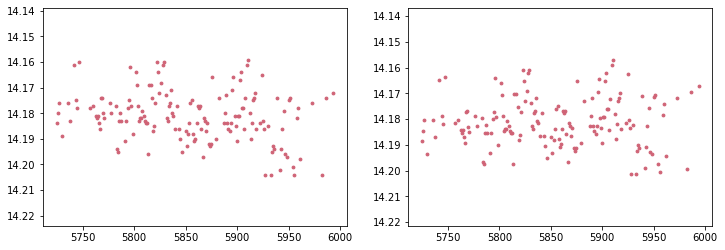

In [19]:
#added mean back after subtraction; default True now
reload(o)
#separate plots since option to not add mean back
detl = o.detline(iband2,st=783,end=938,plot=True,size=8,addmean=True,color=pink)

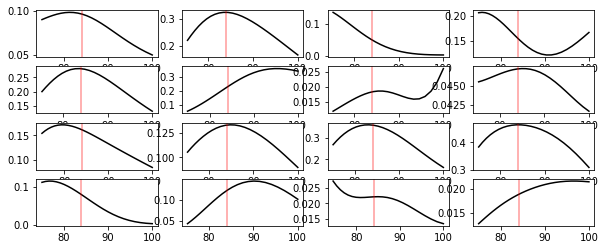

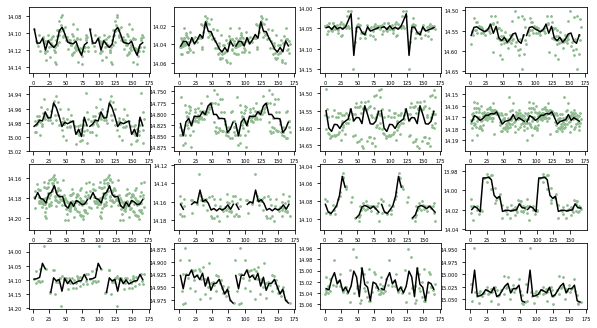

In [21]:
#loop through dense regions and linearly detrend --> periodogram
reload(o)
fig = plt.figure(figsize=(10,5))
fig2 = plt.figure(figsize=(10,7))
p = 1
for d in range(1,len(dense)):
    if dense[d]-dense[d-1]>30:
        st = dense[d-1]
        end = dense[d]
        #temporary tab to not change detrend column in iband2
        ttab = iband2[st:end]
        lindet = o.detline(iband2,st=st,end=end,plot=False,color=pink)
        ttab['I detrend'] = lindet
        freq,power,bp = o.periodogram(ttab,minp=75,maxp=100,more=True,det=True,plot=False,samples=30)
        bps.append(float(bp))
        ax = fig.add_subplot(5,4,p)
        ax.plot(1/freq,power,color='black')
        ax.axvline(84,color='red',alpha=0.4)
        
        ax = fig2.add_subplot(5,4,p)
        ax.scatter(ttab['MJD-50000']%84,lindet,color='darkseagreen',s=3)
        ax.scatter(84+ttab['MJD-50000']%84,lindet,color='darkseagreen',s=3)

        mid,avg = o.meanphase(ttab,84,pbins=20,det=True)
        ax.plot(mid,avg,color='black')
        ax.plot(84+mid,avg,color='black')
        maxi,mini = np.max(lindet),np.min(lindet)
        ax.set_ylim(maxi+.01,mini-.01)
        ax.tick_params(axis='both', labelsize=5 )        
        p+=1

## periodogram on each Og
- look for hundreds-day trend

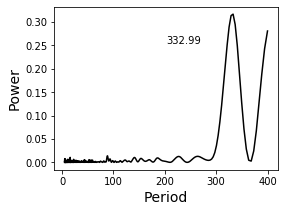

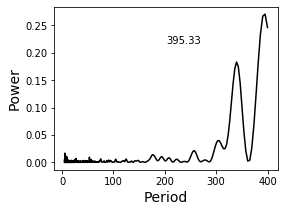

In [22]:
for i in ilist2: #only has OIII and OIV
    o.periodogram(i,maxp=400)

start ind: 0, end ind: -1
start ind: 0, end ind: -1


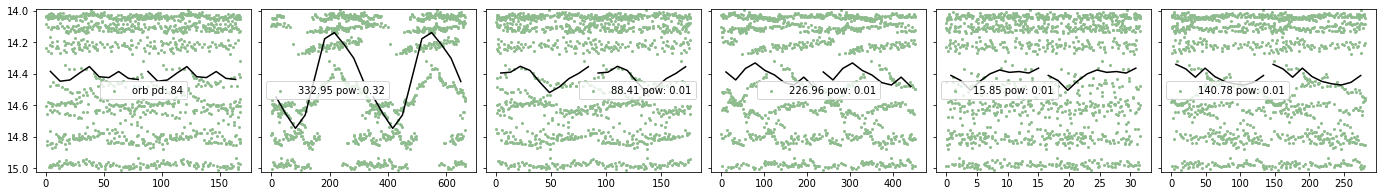

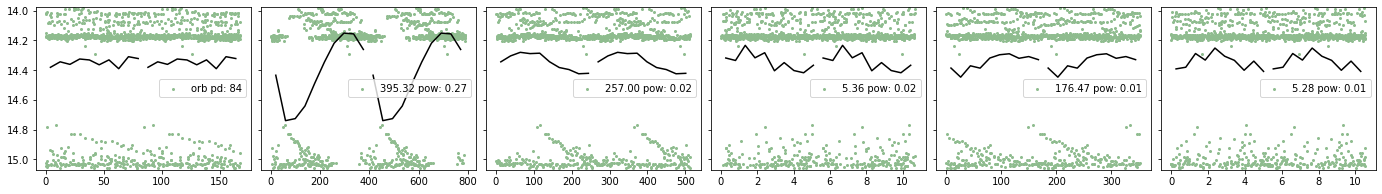

In [23]:
for i in ilist2: #only has OIII and OIV
    df,pks = o.multiphase(i,st=0,end=-1,orb=84,dense=False,maxp=400,sigma=20)

#### real ~400 day trend or just sampling?

(15.1, 13.9)

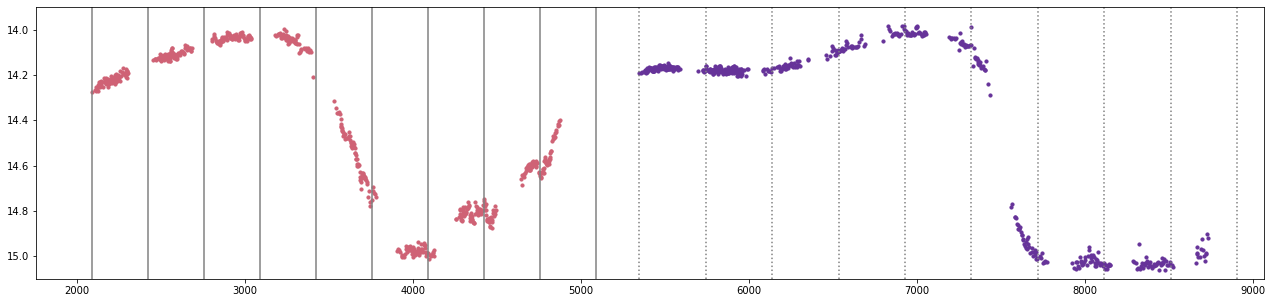

In [24]:
# look for ~400 day trend in full LC
plt.figure(figsize=(22,5))
plt.scatter(ilist2[0]['MJD-50000'],ilist2[0]['I mag'],s=10,color=pink)
plt.scatter(ilist2[1]['MJD-50000'],ilist2[1]['I mag'],s=10,color=purple)

for i in range(10):
    plt.axvline(ilist2[0]['MJD-50000'][0]+332.95*i,color='grey')
    plt.axvline(ilist2[1]['MJD-50000'][0]+395.32*i,color='grey',linestyle='dotted')

plt.ylim(15.1,13.9)

In [25]:
np.array(iband2['MJD-50000'][dense[1:]]) - np.array(iband2['MJD-50000'][dense[:-1]])

array([350.86653, 376.14893, 347.00405, 375.98675, 349.9978 , 386.97621,
       707.02451, 351.97775,  24.98138, 359.04534, 268.57614, 106.41858,
       336.99761,  34.01271, 362.97714, 368.01069, 363.99154, 362.0064 ,
       374.00186])

In [26]:
dense

array([  72,  166,  259,  323,  400,  468,  559,  644,  782,  783,  938,
        986,  988, 1029, 1030, 1080, 1126, 1170, 1217, 1261])

start ind: 166, end ind: 323


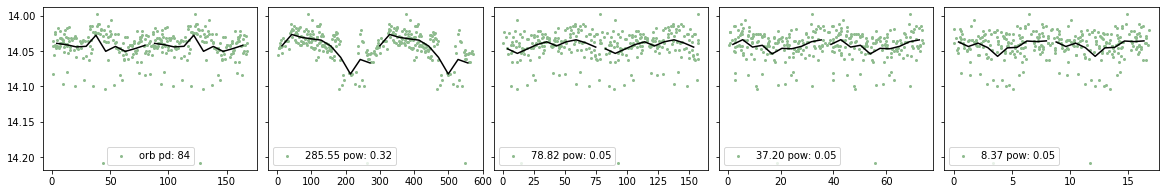

In [27]:
df,pks = o.multiphase(iband2,st=166,end=323,orb=84,dense=False,maxp=400,sigma=20)

# 3: Working Directly With Light Curves
- folding, looking for any other features or changes in periodicity
- so far, 6.7 days, ~orbital period good candidates


#### first just following up on densest region
- repeated from above?

(14.4, 14.35)

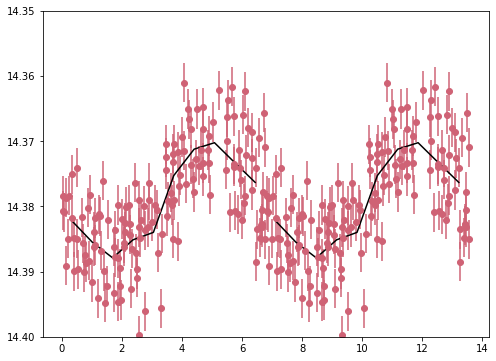

In [28]:
#testing again with detrending but not so necessary
#very small deviations so error relevant
fig = plt.figure(figsize=(8,6))
o.detrend(iband2,window=7,plot=False,figsize=(12,4),size=3)
st = 783
end = 938
plt.errorbar(iband2['MJD-50000'][st:end]%6.78,iband2['I detrend'][st:end],yerr=iband2['I mag err'][st:end],color=pink,linestyle='none',marker='o')
plt.errorbar(6.78+iband2['MJD-50000'][st:end]%6.78,iband2['I detrend'][st:end],yerr=iband2['I mag err'][st:end],color=pink,linestyle='none',marker='o')
mid,avgs = o.meanphase(iband2[st:end],6.78,pbins=10,det=True)
plt.plot(mid,avgs,color='black')
plt.plot(6.78+mid,avgs,color='black')
plt.ylim(14.4,14.35)

### look for orbital period in densest region

(14.22, 14.15)

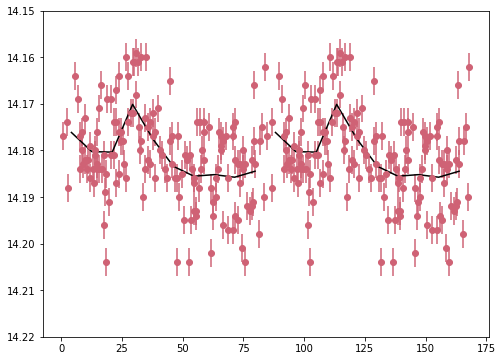

In [29]:
fig = plt.figure(figsize=(8,6))
st = 783
end = 938
orb = 84
plt.errorbar(iband2['MJD-50000'][st:end]%orb,iband2['I mag'][st:end],yerr=iband2['I mag err'][st:end],color=pink,linestyle='none',marker='o')
plt.errorbar(orb+iband2['MJD-50000'][st:end]%orb,iband2['I mag'][st:end],yerr=iband2['I mag err'][st:end],color=pink,linestyle='none',marker='o')
mid,avgs = o.meanphase(iband2[st:end],orb,pbins=10,det=False)
plt.plot(mid,avgs,color='black')
plt.plot(orb+mid,avgs,color='black')
plt.ylim(14.22,14.15)

## going through full LC in chunks
- good summary figure (green points) if you scroll down
- otherwise some exploration of orbital period and other features

(14.27, 14)

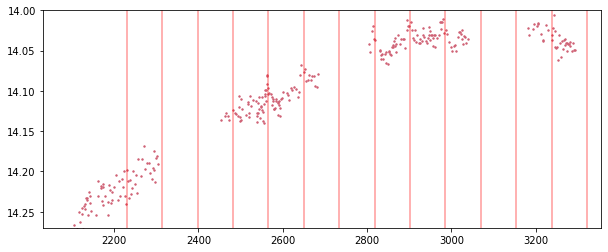

In [30]:
#84 days
plt.figure(figsize=(10,4))
st = 0
end = 300

orb = 84
plt.scatter(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],color=pink,s=2)
# plt.axvline(2185,color='navy',alpha=0.4)
for i in range(14):
    plt.axvline(2230+i*orb,color='red',alpha=0.4)
#     plt.axvline(2185+i*orb,color='navy',alpha=0.4)
plt.ylim(14.27,14)


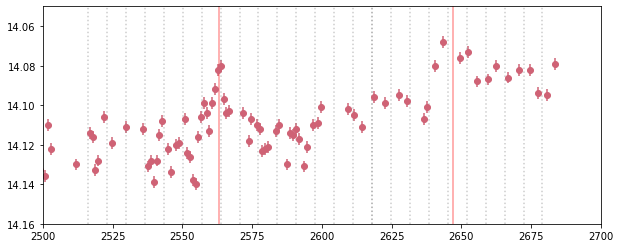

In [31]:
#some suggestion of ~6.7 days but hard with this lower sampling
plt.figure(figsize=(10,4))
plt.errorbar(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],yerr=iband2['I mag err'][st:end],color=pink,linestyle='none',marker='o')
plt.ylim(14.16,14.05)
plt.xlim(2500,2700)
plt.axvline(2563,color='red',alpha=0.4)
plt.axvline(2563+84,color='red',alpha=0.4)
plt.axvline(2618,color='grey',alpha=0.4,linestyle='dotted')
for i in range(-15,10):
    plt.axvline(2618+6.7858*i,color='grey',alpha=0.4,linestyle='dotted')


- 84 days good in describing spacing (red)
- need precision but ~6.79 days good in describing high points especially in first 3/4 of plot

start ind: 100, end ind: 165


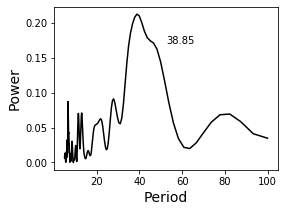

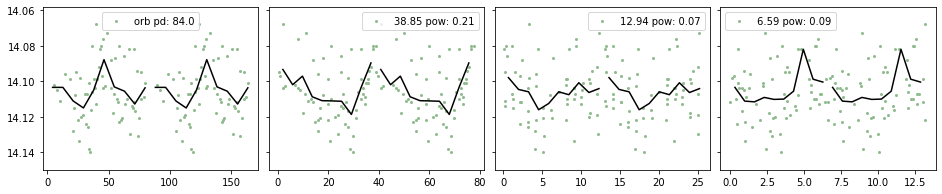

In [32]:
df,pks = o.multiphase(iband2,st=100,end=165,dense=False,orb=orb_dict[2],sigma=10,plotpd=True)

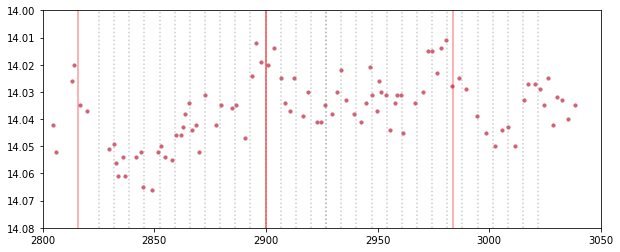

In [33]:
plt.figure(figsize=(10,4))
plt.scatter(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],color=pink,s=10)
plt.ylim(14.08,14)
plt.xlim(2800,3050)
plt.axvline(2900,color='red',alpha=0.4)
plt.axvline(2563+84,color='red',alpha=0.4)
plt.axvline(2927,color='grey',alpha=0.4,linestyle='dotted')
for i in range(-15,15):
    plt.axvline(2927+6.7858*i,color='grey',alpha=0.4,linestyle='dotted')
    plt.axvline(2900+84*i,color='red',alpha=0.4)

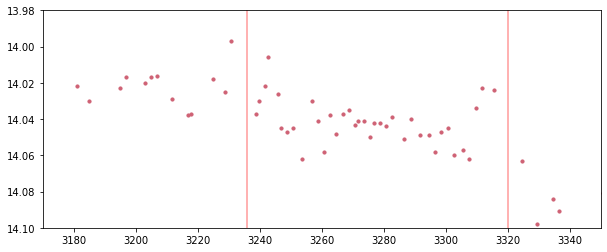

In [34]:
plt.figure(figsize=(10,4))
plt.scatter(iband2['MJD-50000'],iband2['I mag'],color=pink,s=10)
plt.ylim(14.1,13.98)
plt.xlim(3170,3350)
plt.axvline(2900,color='red',alpha=0.4)
plt.axvline(2563+84,color='red',alpha=0.4)
plt.axvline(2927,color='grey',alpha=0.4,linestyle='dotted')
for i in range(1,10): #continuing 84 day from previous
    plt.axvline(2900+84*i,color='red',alpha=0.4)
# for i in range(-13,10):
#     plt.axvline(3282+6.81*i,color='grey',alpha=0.4,linestyle='dotted')
#having trouble with ~6 day here (multiphase below)

In [35]:
iband2[310:315]

MJD-50000,I mag,I mag err,I detrend
float64,float64,float64,float64
3324.60374,14.063,0.003,14.372934841021053
3329.57567,14.098,0.003,14.399649126735333
3334.59211,14.084,0.003,14.377077698163903
3336.59075,14.091,0.003,14.387220555306762
3350.59103,14.081,0.003,14.37250626959248


start ind: 259, end ind: 315


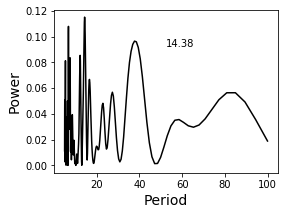

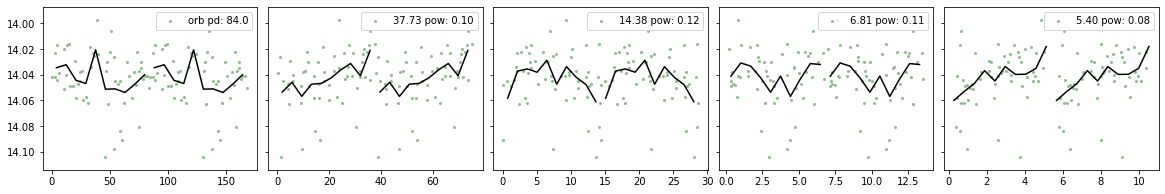

In [36]:
df,pks = o.multiphase(iband2,st=259,end=315,dense=False,orb=orb_dict[2],sigma=10,plotpd=True)

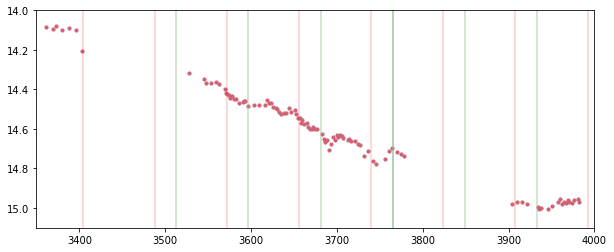

In [37]:
#over larger region
st = 316
end = 420
plt.figure(figsize=(10,4))
plt.scatter(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],color=pink,s=10)
plt.ylim(15.1,14.0)
plt.xlim(3350,4000)
for i in range(5,20): #continuing 84 day from previous
    plt.axvline(2900+84*i,color='red',alpha=0.2) #continuing trend of 84 days
plt.axvline(3765,color='darkseagreen',alpha=0.6,label='by-eye')
for i in range(-3,3):
    plt.axvline(3765+84*i,color='darkseagreen',alpha=0.5)

hard to tell what's going on in region above

start ind: 323, end ind: 400


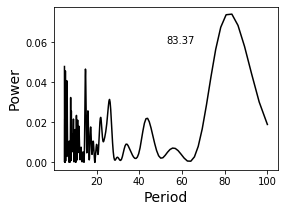

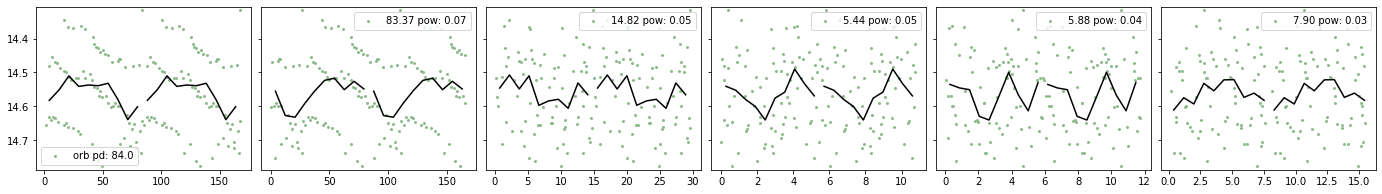

In [38]:
df,pks = o.multiphase(iband2,st=323,end=400,dense=False,orb=orb_dict[2],sigma=10,plotpd=True)

### good opportunity to try detrending just with a line

In [39]:
st=323
end=400
mod = np.polyfit(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],1)
mod2 = np.polyfit(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],2)

(14.8, 14.3)

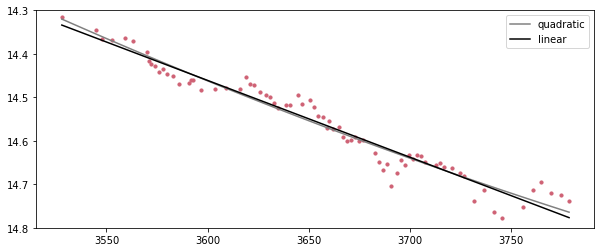

In [40]:
#middle part
plt.figure(figsize=(10,4))
plt.scatter(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],color=pink,s=10)
# plt.ylim(14.1,13.98)
t = iband2['MJD-50000'][st:end]
#illustrating difference between linear and quadratic
plt.plot(t,mod2[0]*t**2+mod2[1]*t+mod2[2],color='grey',label='quadratic')
plt.plot(t,mod[0]*t+mod[1],color='black',label='linear')
plt.legend()
plt.ylim(14.8,14.3)

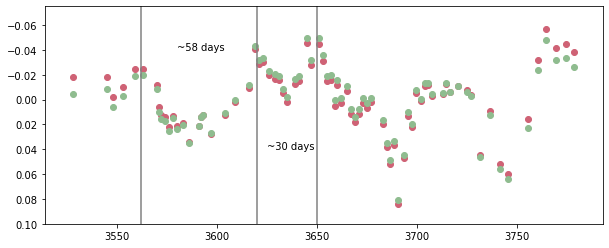

In [41]:
#plot detrended with line and quadratic function
#not really different in this case
plt.figure(figsize=(10,4))
lindet = iband2['I mag'][st:end] - (t*mod[0]+mod[1])
quadet = iband2['I mag'][st:end] - (t**2*mod2[0]+mod2[1]*t+mod2[2])

plt.scatter(t,lindet,color=pink)
plt.scatter(t,quadet,color='darkseagreen')
plt.ylim(.1,-.075)
#put lines at features
plt.axvline(3562,color='grey')
plt.text(3580,-.04,'~58 days')
plt.text(3625,.04,'~30 days')

plt.axvline(3620,color='grey')
plt.axvline(3650,color='grey')

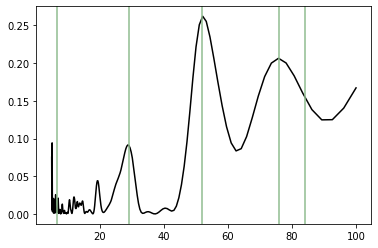

In [42]:
#periodogram using linear detrending
minf = 1/100
maxf = 1/5
ls = LombScargle(iband2['MJD-50000'][st:end],lindet)
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=10)
plt.plot(1/freq,power,color='black')
plt.axvline(6.8,color='darkseagreen')
plt.axvline(84,color='darkseagreen')
plt.axvline(76,color='darkseagreen')

plt.axvline(52,color='darkseagreen')
plt.axvline(29,color='darkseagreen')

(<matplotlib.legend.Legend at 0x1a23124390>,
 <matplotlib.legend.Legend at 0x1a25be14d0>)

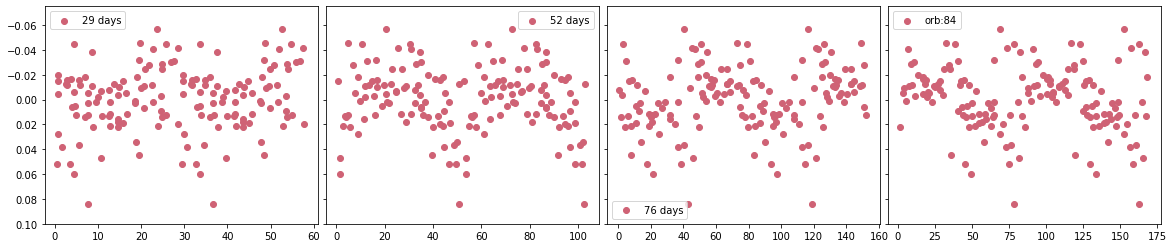

In [43]:
#phase-fold linearly detrended
fig,(ax,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(20,4),sharey=True)
plt.subplots_adjust(wspace=.03)
p = 29
ax.scatter(t%p,lindet,color=pink,label='29 days')
ax.scatter(p+t%p,lindet,color=pink)
p = 52
ax1.scatter(t%p,lindet,color=pink,label='52 days')
ax1.scatter(p+t%p,lindet,color=pink)
p = 76
ax2.scatter(t%p,lindet,color=pink,label='76 days')
ax2.scatter(p+t%p,lindet,color=pink)
p = 84
ax3.scatter(t%p,lindet,color=pink,label='orb:84')
ax3.scatter(p+t%p,lindet,color=pink)
ax.set_ylim(.1,-.075)
ax.legend(),ax1.legend(),ax2.legend(),ax3.legend()


Text(0.5, 0, 'MJD-50000')

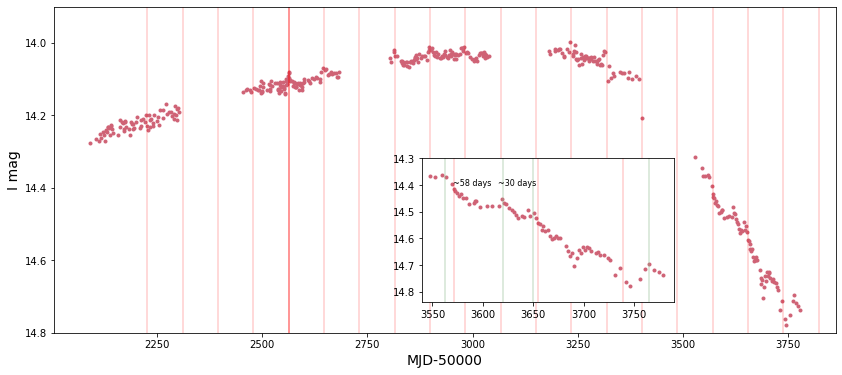

In [44]:
fs = figsize=(14,6)
fig,ax = plt.subplots(1,1,figsize=fs)
tbig = iband2['MJD-50000'][:end]
ibig = iband2['I mag'][:end]
mod3 = np.polyfit(tbig,ibig,3)
ax.scatter(tbig,ibig,color=pink,s=9)
# func = mod3[0]*tbig**3+mod3[1]*tbig**2+mod3[2]*tbig+mod3[3]
# plt.plot(tbig,func,color='black')
ax.set_ylim(14.8,13.9)
#track orbital period
ax.axvline(2563,color='red',alpha=0.4)
#inset the features after 3500
axins = inset_axes(ax, width=figsize[0]/4, height=figsize[1]/3,
                   bbox_to_anchor=(0.2, .05, .6, .5),
                   bbox_transform=ax.transAxes)
axins.scatter(tbig[325:],ibig[325:],s=9,color=pink)
axins.set_ylim(14.84,14.3)
axins.set_xlim(3540,)
for i in range(-4,16):
    ax.axvline(2563+84*i,color='red',alpha=0.2)
    axins.axvline(2563+84*i,color='red',alpha=0.2)
#put other features in inset
axins.axvline(2563+84*i,color='darkseagreen',alpha=0.4)

axins.axvline(3562,color='darkseagreen',alpha=0.4)
axins.text(3570,14.4,'~58 days',fontsize=8)
axins.text(3615,14.4,'~30 days',fontsize=8)

axins.axvline(3620,color='darkseagreen',alpha=0.4)
axins.axvline(3650,color='darkseagreen',alpha=0.4)
axins.axvline(3765,color='darkseagreen',alpha=0.4)

ax.set_ylabel('I mag',fontsize=14)
ax.set_xlabel('MJD-50000',fontsize=14)

# continue onward with next part of LC
- with this source, should at least space lines by 84 days on whole LC (or with continuous start date but LC in segments)

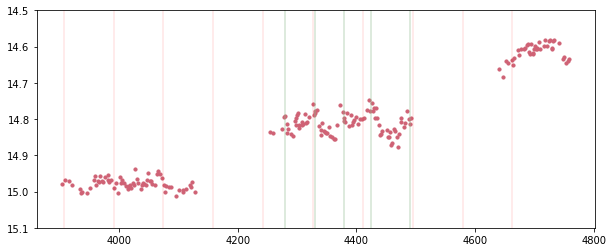

In [45]:
st = 400
end = 600
plt.figure(figsize=(10,4))
plt.scatter(iband2['MJD-50000'][st:end],iband2['I mag'][st:end],color=pink,s=10)
for i in range(16,26):
    plt.axvline(2563+84*i,color='red',alpha=0.1)
plt.ylim(15.1,14.5)
#identify peaks here
plt.axvline(4425,color='darkseagreen',alpha=0.4)
#difference of 45 days
plt.axvline(4380,color='darkseagreen',alpha=0.4)
#65 days
plt.axvline(4425+65,color='darkseagreen',alpha=0.4)
#50 days
plt.axvline(4425-95,color='darkseagreen',alpha=0.4)
plt.axvline(4425-145,color='darkseagreen',alpha=0.4)


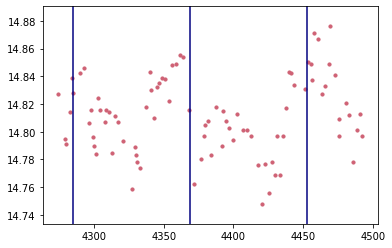

In [46]:
#middle region with 84 day spacing -- could just be irregular shapes
plt.scatter(iband2['MJD-50000'][470:559],iband2['I mag'][470:559],color=pink,s=10)
plt.axvline(4285,color='navy')
plt.axvline(4285+84,color='navy')
plt.axvline(4285+84+84,color='navy')


<Quantity 95.62700409>

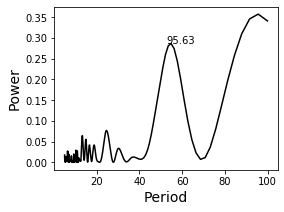

In [47]:
o.periodogram(iband2[470:559],maxp=100)

start ind: 470, end ind: 559


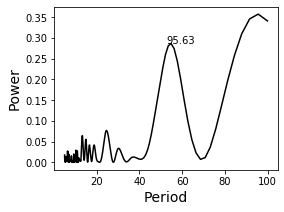

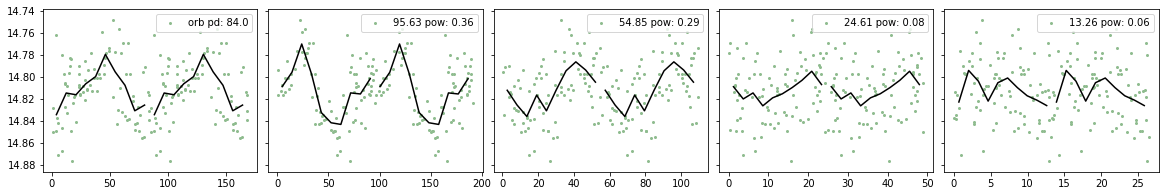

In [48]:
reload(o)
#example where plotting periodogram helpful if check possible otherwise it misses 54 day peak
df,pks = o.multiphase(iband2,st=470,end=559,dense=False,orb=orb_dict[2],sigma=20,plotpd=True,distance=10)

In [49]:
pks

(array([  1,  18,  67, 143]),
 {'peak_heights': array([0.35726172, 0.28650238, 0.07708303, 0.06448909])})

(14.88, 14.74)

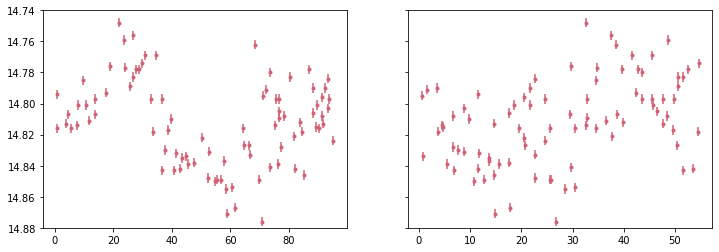

In [50]:
#just plotting top two phase-foldings again
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
ax[0].errorbar(iband2['MJD-50000'][470:559]%95.627004,iband2['I mag'][470:559],yerr=iband2['I mag err'][470:559],linestyle='none',marker='o',color=pink,markersize=3)
ax[1].errorbar(iband2['MJD-50000'][470:559]%54.85,iband2['I mag'][470:559],yerr=iband2['I mag err'][470:559],linestyle='none',marker='o',color=pink,markersize=3)
ax[0].set_ylim(14.88,14.74)

(14.7, 14.35)

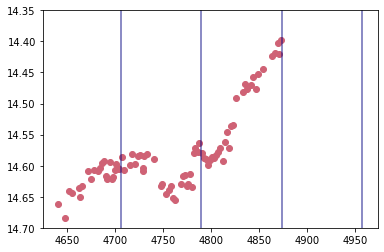

In [51]:
#next segment
plt.scatter(iband2['MJD-50000'][559:644],iband2['I mag'][559:644],color=pink)

plt.axvline(4790,color='navy',alpha=0.6)
plt.axvline(4790+84,color='navy',alpha=0.6)
plt.axvline(4790+84+84,color='navy',alpha=0.6)
plt.axvline(4790-84,color='navy',alpha=0.6)
plt.ylim(14.7,14.35)

start ind: 559, end ind: 644


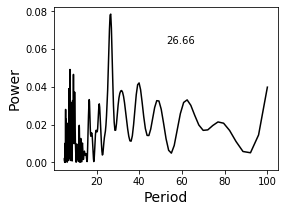

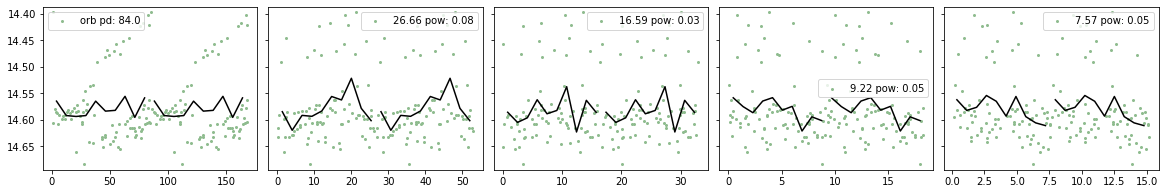

In [52]:
#run periodogram on this segment
df,pks = o.multiphase(iband2,st=559,end=644,dense=False,orb=orb_dict[2],sigma=10,plotpd=True)

(14.2, 14.14)

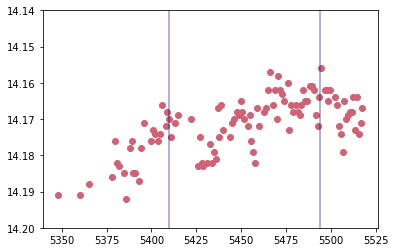

In [53]:
#next segment
plt.scatter(iband2['MJD-50000'][644:750],iband2['I mag'][644:750],color=pink)
plt.axvline(5410,color='navy',alpha=0.4)
plt.axvline(5410+84,color='navy',alpha=0.4)

plt.ylim(14.2,14.14)

start ind: 644, end ind: 750


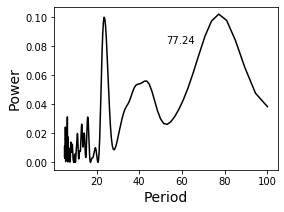

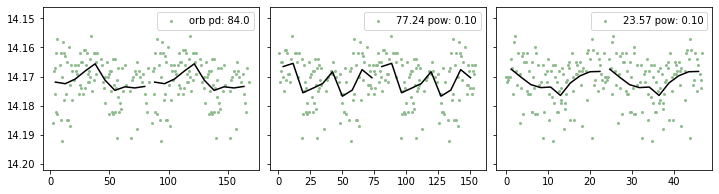

In [54]:
df,pks = o.multiphase(iband2,st=644,end=750,dense=False,orb=orb_dict[2],sigma=10,plotpd=True)

# 4: Final LC Chunks With Lines Spaced by 84 days --> Completely Effective?


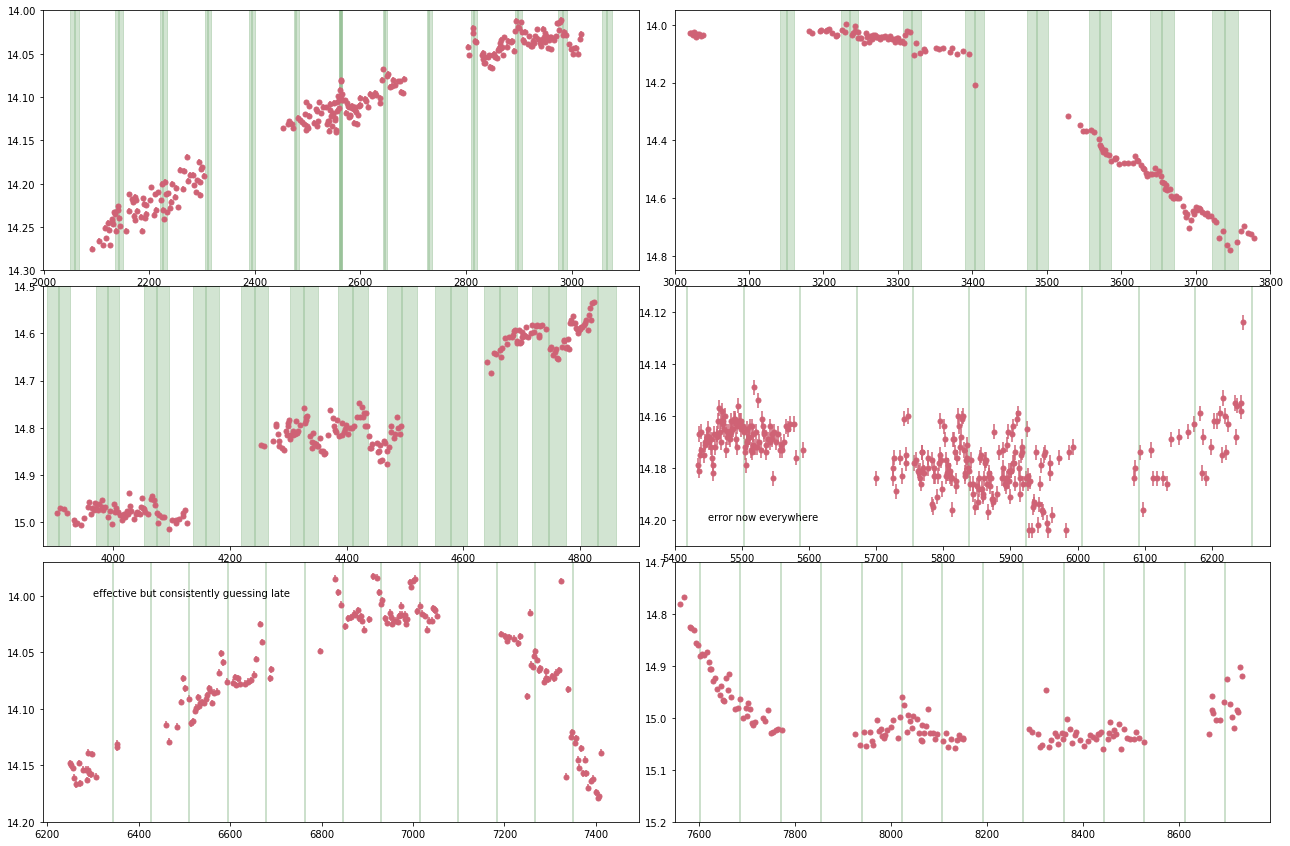

In [55]:
#making into function to remake plot below but slightly different
def lcorb(pd=84,pderr=1,cen=2563,cenerr=3): #can't change to a new flare but can change center
    '''Currently specific to source but generalize in the future
    Chunks of LC plotted separately b/c of large amplitude (easier to see when only amplitude range in chunk shown)
    Shows orbital period, and with propagated approx. error in first few subplots
    Center determined by-eye in cell below'''
    fig = plt.figure(figsize=(22,20))
    ax = fig.add_subplot(4,2,1)
    ax.errorbar(iband2['MJD-50000'][:250],iband2['I mag'][:250],yerr=iband2['I mag err'][:250],linestyle='none',marker='o',color=pink,markersize=5)
    ax.set_ylim(14.3,14)
    for i in range(0,7):
        #propogate error of ~3 days and 1 day on period
        ax.axvspan(cen-cenerr+(pd-pderr)*i,cen+cenerr+(pd+pderr)*i,color='darkseagreen',alpha=0.4)
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
    for i in range(-6,1):
        #propogate error of ~3 days
        ax.axvspan(2560+85*i,2566+83*i,color='darkseagreen',alpha=0.4)
        ax.axvline(2563+84*i,color='darkseagreen',alpha=0.6)
    
    #next plot, try to continue origin and error
    ax = fig.add_subplot(4,2,2)
    ax.errorbar(iband2['MJD-50000'][250:400],iband2['I mag'][250:400],yerr=iband2['I mag err'][250:400],linestyle='none',marker='o',color=pink,markersize=5)
    ax.set_ylim(14.85,13.95)
    ax.set_xlim(3000,3800)
    plt.subplots_adjust(wspace=.06)
    for i in range(7,20):
        #propogate error of ~3 days and 1 day on period
        ax.axvspan(cen-cenerr+(pd-pderr)*i,cen+cenerr+(pd+pderr)*i,color='darkseagreen',alpha=0.4)
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
    
    ax = fig.add_subplot(4,2,3)
    ax.errorbar(iband2['MJD-50000'][400:690],iband2['I mag'][400:690],yerr=iband2['I mag err'][400:690],linestyle='none',marker='o',color=pink,markersize=5)
    ax.set_ylim(15.05,14.5)
    ax.set_xlim(3880,4900)
    plt.subplots_adjust(hspace=.06)
    for i in range(16,28):
        #propogate error of ~3 days and 1 day on period
        ax.axvspan(cen-cenerr+(pd-pderr)*i,cen+cenerr+(pd+pderr)*i,color='darkseagreen',alpha=0.4)
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
    
    #densest region, where 6.78 found; notice low variability comparatively
    ax = fig.add_subplot(4,2,4)
    ax.errorbar(iband2['MJD-50000'][680:970],iband2['I mag'][680:970],yerr=iband2['I mag err'][680:970],linestyle='none',marker='o',color=pink,markersize=5)
    ax.set_ylim(14.21,14.11)
    ax.set_xlim(5400,)
    plt.subplots_adjust(hspace=.06)
    ax.text(5450,14.2,'error now everywhere')
    for i in range(34,48):
        #error so high that they all meet now... so just putting 84 days 
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
    
    ax = fig.add_subplot(4,2,5)
    ax.errorbar(iband2['MJD-50000'][970:1126],iband2['I mag'][970:1126],yerr=iband2['I mag err'][970:1126],linestyle='none',marker='o',color=pink,markersize=5)
    ax.set_ylim(14.2,13.97)
    # ax.set_xlim(5400,)
    plt.subplots_adjust(hspace=.06)
    for i in range(45,58):
        #error so high that they all meet now... so just putting 84 days 
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
    ax.text(6300,14,'effective but consistently guessing late')

    ax = fig.add_subplot(4,2,6)
    ax.errorbar(iband2['MJD-50000'][1126:],iband2['I mag'][1126:],yerr=iband2['I mag err'][1126:],linestyle='none',marker='o',color=pink,markersize=5)
    ax.set_ylim(15.2,14.7)
    ax.set_xlim(7550,)
    plt.subplots_adjust(hspace=.06)
    for i in range(57,74):
        #error so high that they all meet now... so just putting 84 days 
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
lcorb()

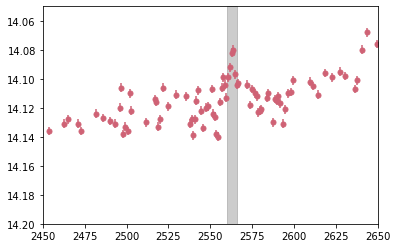

In [56]:
plt.errorbar(iband2['MJD-50000'][:250],iband2['I mag'][:250],yerr=iband2['I mag err'][:250],linestyle='none',marker='o',color=pink,markersize=5)
plt.ylim(14.2,14.05)
plt.xlim(2450,2650)
plt.axvspan(2560,2566,color='grey',alpha=0.4)

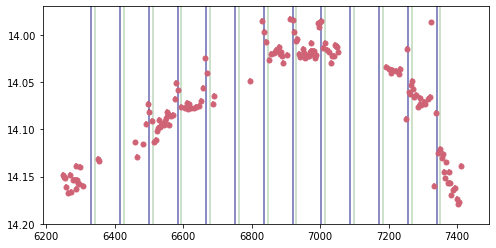

In [57]:
#subplot 5 where 84 day always late
#navy just restarts 84 day separation within this region

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.errorbar(iband2['MJD-50000'][970:1126],iband2['I mag'][970:1126],yerr=iband2['I mag err'][970:1126],linestyle='none',marker='o',color=pink,markersize=5)
ax.set_ylim(14.2,13.97)
# ax.set_xlim(5400,)
plt.subplots_adjust(hspace=.06)
for i in range(45,58):
    #error so high that they all meet now... so just putting 84 days 
    ax.axvline(2563+84*i,color='darkseagreen',alpha=0.6)
for i in range(-2,11):
    #error so high that they all meet now... so just putting 84 days 
    ax.axvline(6500+84*i,color='navy',alpha=0.6)

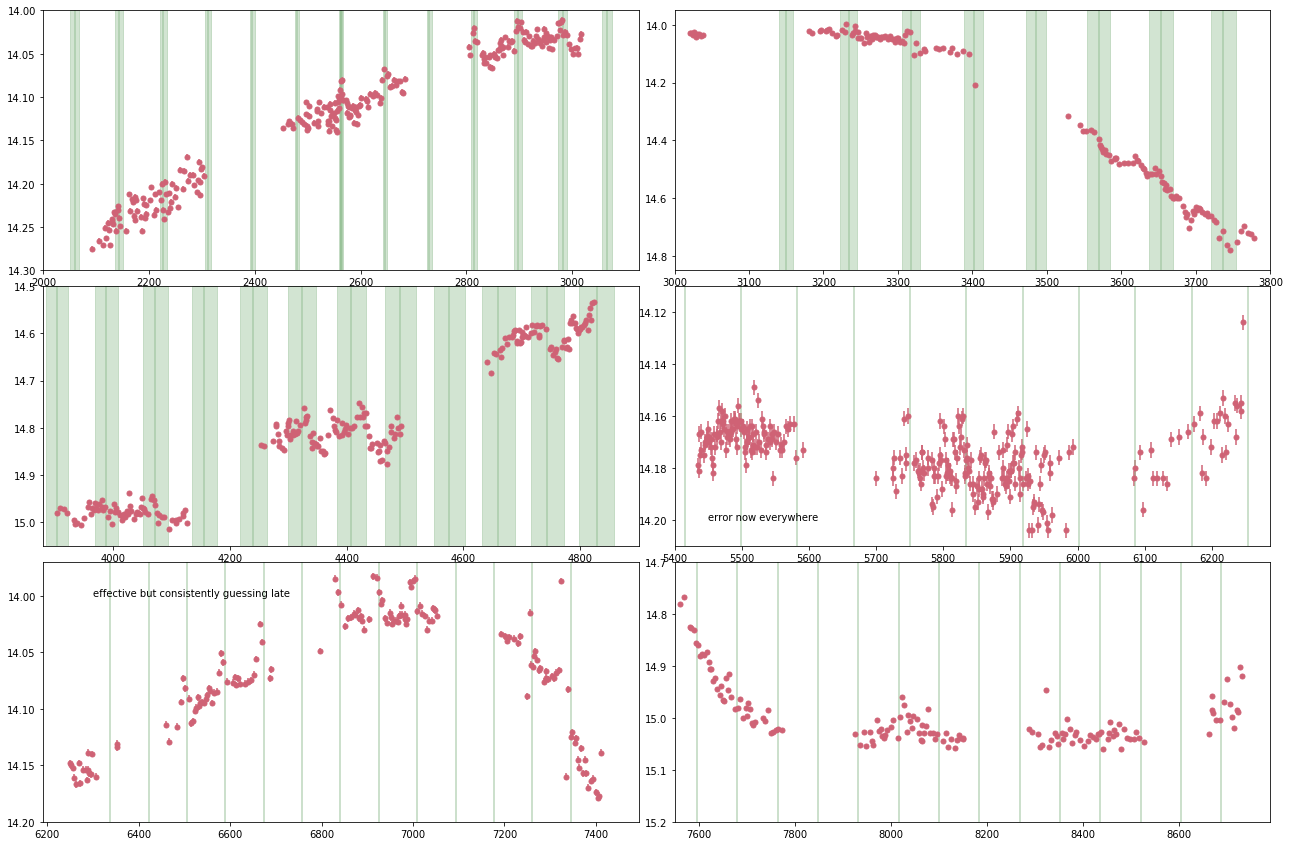

In [58]:
#experiment with lower orbital period and/or lower first flare center: keep an eye on bottom row
lcorb(pd=83.9,cen=2562.4)

#### futher investimate 6200 days to end
- seeing that flares predicted late in bottom row on left but early on right... suggests change!

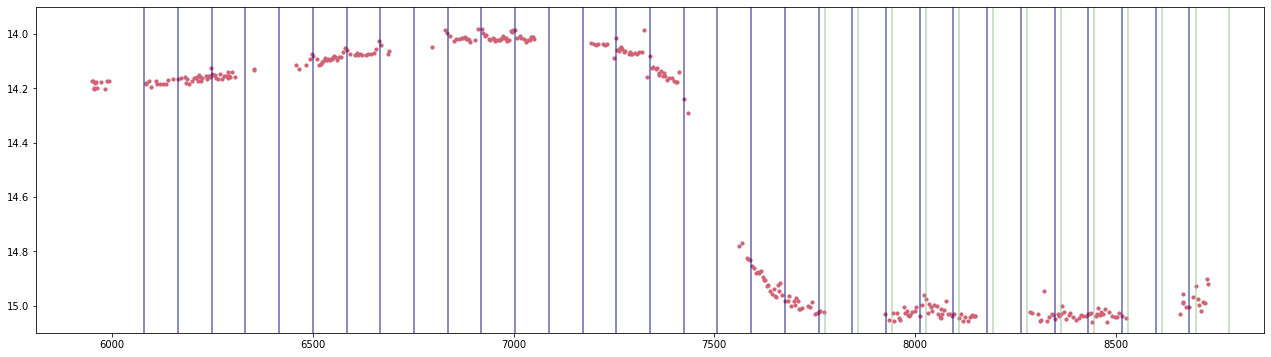

In [59]:
plt.figure(figsize=(22,6))
plt.scatter(iband2['MJD-50000'][927:],iband2['I mag'][927:],color=pink,s=10)
plt.ylim(15.1,13.9)
for i in range(-5,27):
    #error so high that they all meet now... so just putting 84 days 
    plt.axvline(6500+84*i,color='navy',alpha=0.6)
#now retry in bottom region
for i in range(-3,10):
    plt.axvline(8027+84*i,color='darkseagreen',alpha=0.6)
#another option is slight increse on period

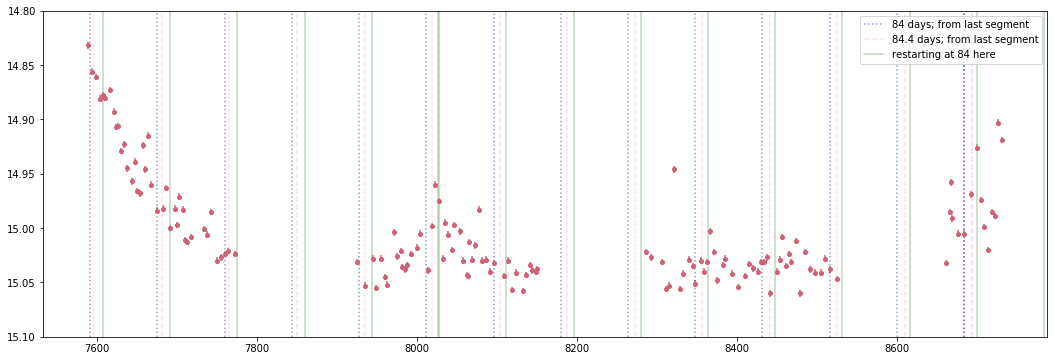

In [60]:
#zoom in on last bit to help
plt.figure(figsize=(18,6))
plt.errorbar(iband2['MJD-50000'][1130::],iband2['I mag'][1130:],yerr=iband2['I mag err'][1130:],color=pink,linestyle='none',marker='o',markersize=4)
for i in range(13,27):
    #error so high that they all meet now... so just putting 84 days 
    plt.axvline(6500+84*i,color='navy',alpha=0.4,linestyle='dotted')
    plt.axvline(6500+84.4*i,color='pink',alpha=0.4,linestyle='dashed')
plt.axvline(6500+84*i,color='navy',alpha=0.4,linestyle='dotted',label='84 days; from last segment')
plt.axvline(6500+84.4*i,color='pink',alpha=0.4,linestyle='dashed',label='84.4 days; from last segment')
plt.ylim(15.1,14.8)
for i in range(-5,10):
    plt.axvline(8028+84*i,color='darkseagreen',alpha=0.6)
plt.axvline(8027,color='darkseagreen',alpha=0.6,label='restarting at 84 here')
plt.legend()

In [61]:
iband2[1220:1225]

MJD-50000,I mag,I mag err,I detrend
float64,float64,float64,float64
8310.88798,15.056,0.003,14.408220555306762
8314.88567,15.053,0.003,14.402363412449622
8321.83281,14.946,0.003,14.295077698163905
8328.84427,15.056,0.003,14.404506269592478
8332.85299,15.042,0.003,14.391220555306763


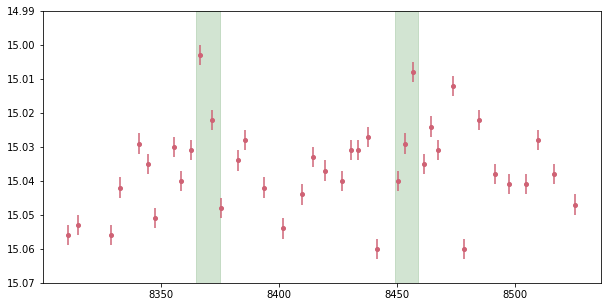

In [62]:
#two flares around 8400
plt.figure(figsize=(10,5))
plt.errorbar(iband2['MJD-50000'][1220:-15],iband2['I mag'][1220:-15],yerr=iband2['I mag err'][1220:-15],linestyle='none',color=pink,marker='o',markersize=4)
plt.ylim(15.07,14.99)
plt.axvspan(8365,8375,color='darkseagreen',alpha=0.4)
plt.axvspan(8365+84,8375+84,color='darkseagreen',alpha=0.4)

start ind: 1130, end ind: -1


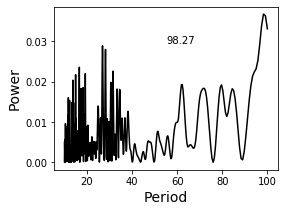

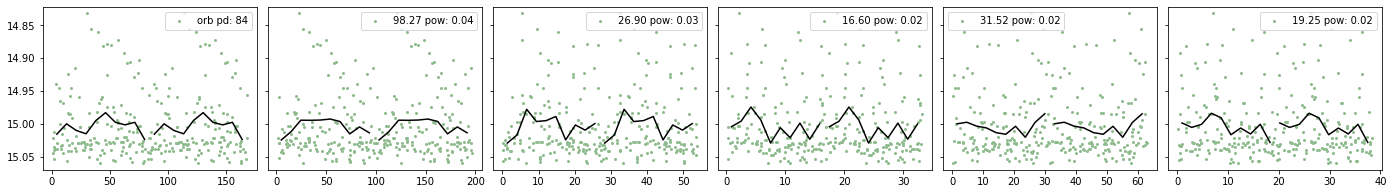

In [63]:
df,pks = o.multiphase(iband2,st=1130,end=-1,orb=84,minp=10,maxp=100,dense=False,sigma=10,plotpd=True)

#### any flares in V band?

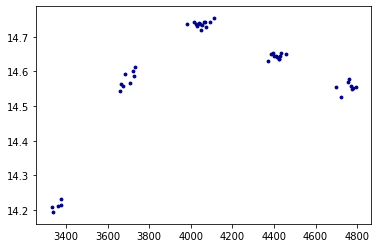

In [64]:
plt.scatter(vband2['MJD-50000'],vband2['V mag'],color='navy',s=8)

# To Do: Look at Amplitdues for Orbital Period Flares
- compare to larger trend
- compare peak or all flare points to median, stdev
    - overall constant stdev? more variability at some point in LC?

peaks are too small (and therefore frequent) here to get anything significant

# 5: Possiblity: Classes/Objects
- not sure how to best integrate with existing moduel
    - e.g. here: called getIV function but slightly easier b/c just called on object
    - not super necessary, but helpful for some functions to have object with srcn, orb, etc.
- easy for variables if always the same name
- can add on to object during analysis
    - but can also keep some sort of table that can do analogous thing

In [65]:
class Source:
    def __init__(self, srcn):
        self.srcn = srcn
        self.orb = orb_dict[srcn]
        self.ra = ra_dict[srcn]
        self.dec = dec_dict[srcn]
    def lc(self,stack=True,both=True,plot=False,size=4,figsize=(8,4),zooms=False,mult=(3,40),offset=0):
        i,v = o.getIV(self.srcn,cross,stack=stack,both=both,plot=plot,size=size,figsize=figsize,zooms=zooms,mult=mult,offset=offset)
        if stack:
            #full tables
            self.i = i
            self.v = v
            #individual columns
            self.idays,self.vdays = i['MJD-50000'],v['MJD-50000']
            self.imag,self.vmag = i['I mag'],v['V mag']
            self.imax,self.imin = np.max(i['I mag']),np.min(i['I mag'])
            self.ierr,self.verr = i['I mag err'],v['V mag err']
        else:
            self.i = vstack(i)
            self.v = vstack(v)
            self.ilist = i
            self.vlist = v
    def plotlc(self,color='palevioletred',size=2):
        plt.errorbar(self.idays,self.imag,yerr=self.ierr,marker='o',linestyle='none',color=color,markersize=size)
        plt.ylim(self.imax+.04,self.imin-.04)

In [66]:
src2 = Source(2)

In [67]:
src2.ra

'01:21:40.61'

In [68]:
src2.lc()

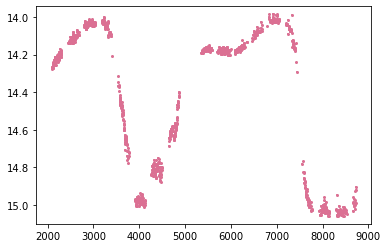

In [69]:
src2.plotlc()

# 6: Example Showing Many Source LCs and V-I
- change into function once working

In [70]:
reload(o)
def gallery(n=0): #assumes several variables defined already
    fig = plt.figure(figsize=(22,18))
    plt.subplots_adjust(wspace=.25,hspace=.25)
    c = 1
    while c < 20:
        i,v = o.getIV(cross['src_n'][n],cross,stack=True,both=True,plot=False,size=2)
        ax = fig.add_subplot(5,4,c)
        ax.scatter(i['MJD-50000'],i['I mag'],color=pink,s=3)
        ax.set_title(str(cross['src_n'][n]))
        maxi,mini = np.max(i['I mag']),np.min(i['I mag'])
        ax.set_ylim(maxi+.015,mini-.015)
        c+=1
        n+=1
        #color-mag
        ax = fig.add_subplot(5,4,c)
        i_interp = o.colormag(i,v,plot=False,printcorr=False)
        #scatter I vs V-I
        ax.scatter(v['V mag']-i_interp,i_interp,color='black',s=3)
        ax.set_ylim(maxi+.01,mini-.01)
        c+=1
    return n

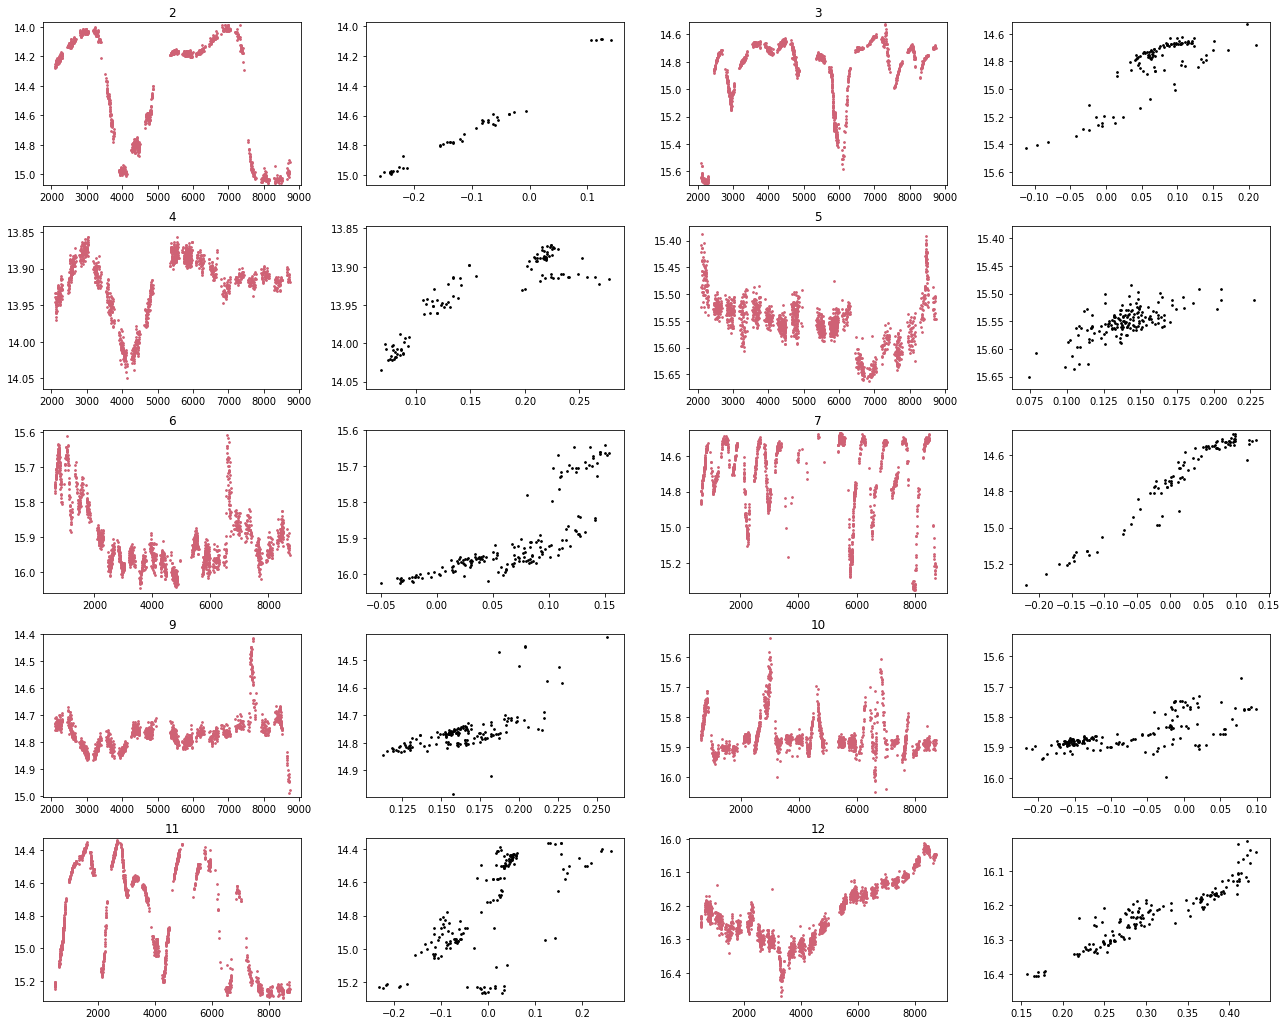

In [71]:
n = gallery()

- continue in groups of 10
- below: example of bluer when brighter and switches

20

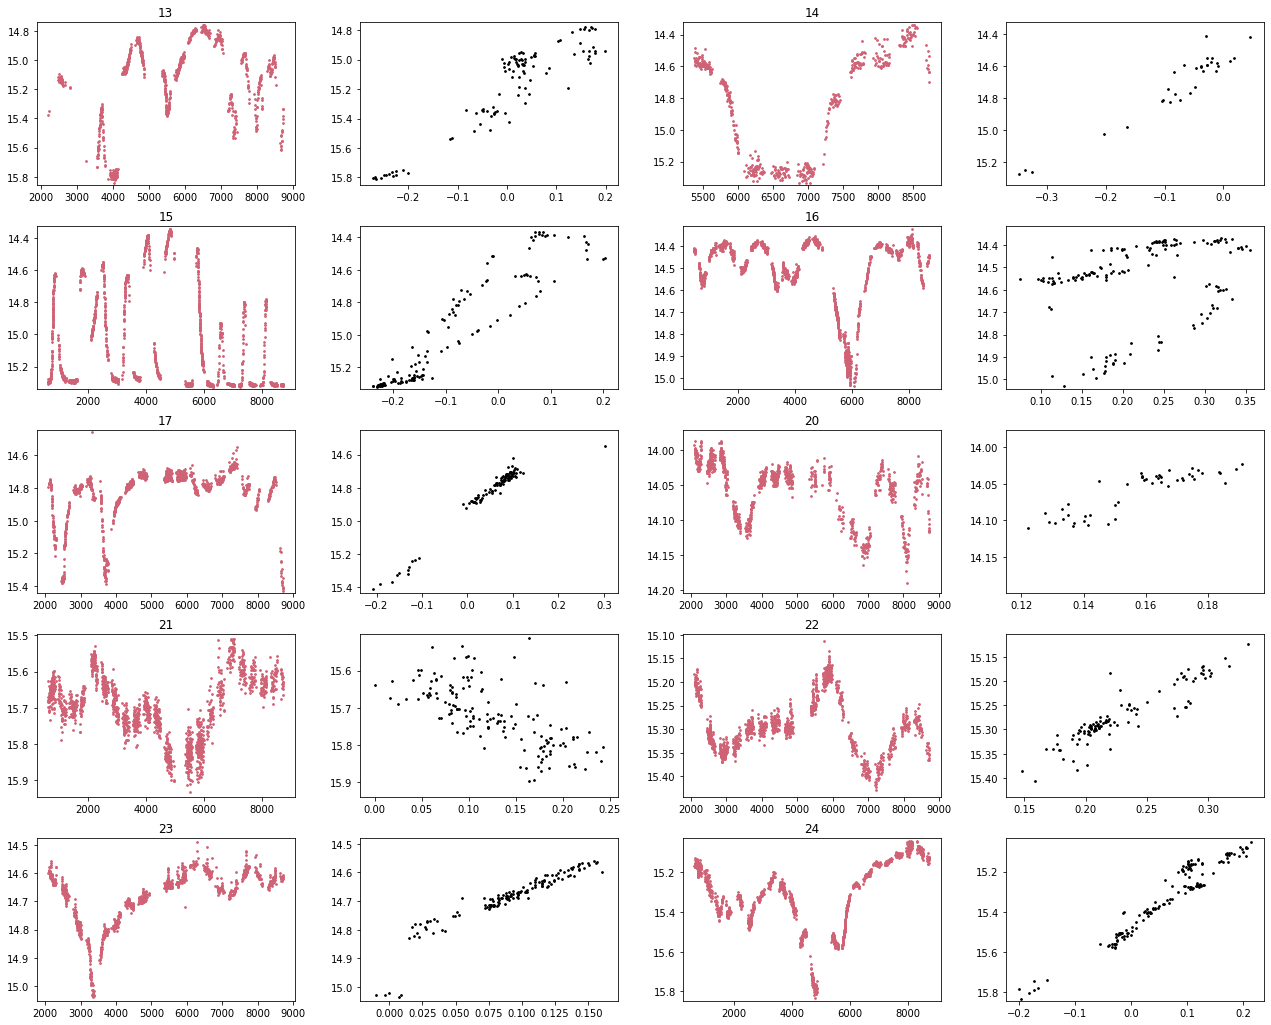

In [72]:
#repeat for next 10 sources
gallery(n=10)

30

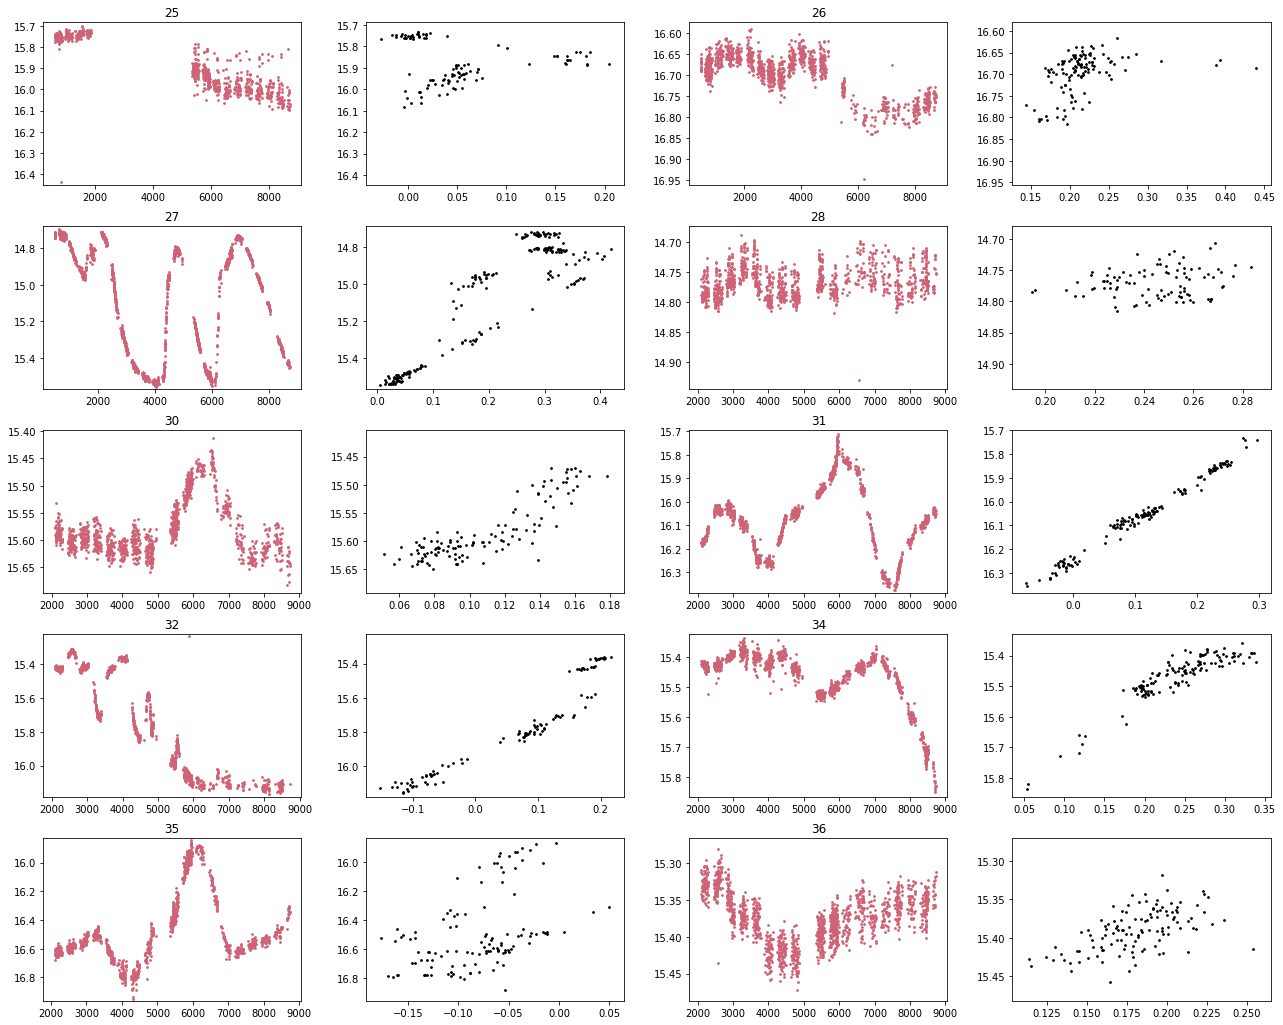

In [73]:
gallery(n=20)

40

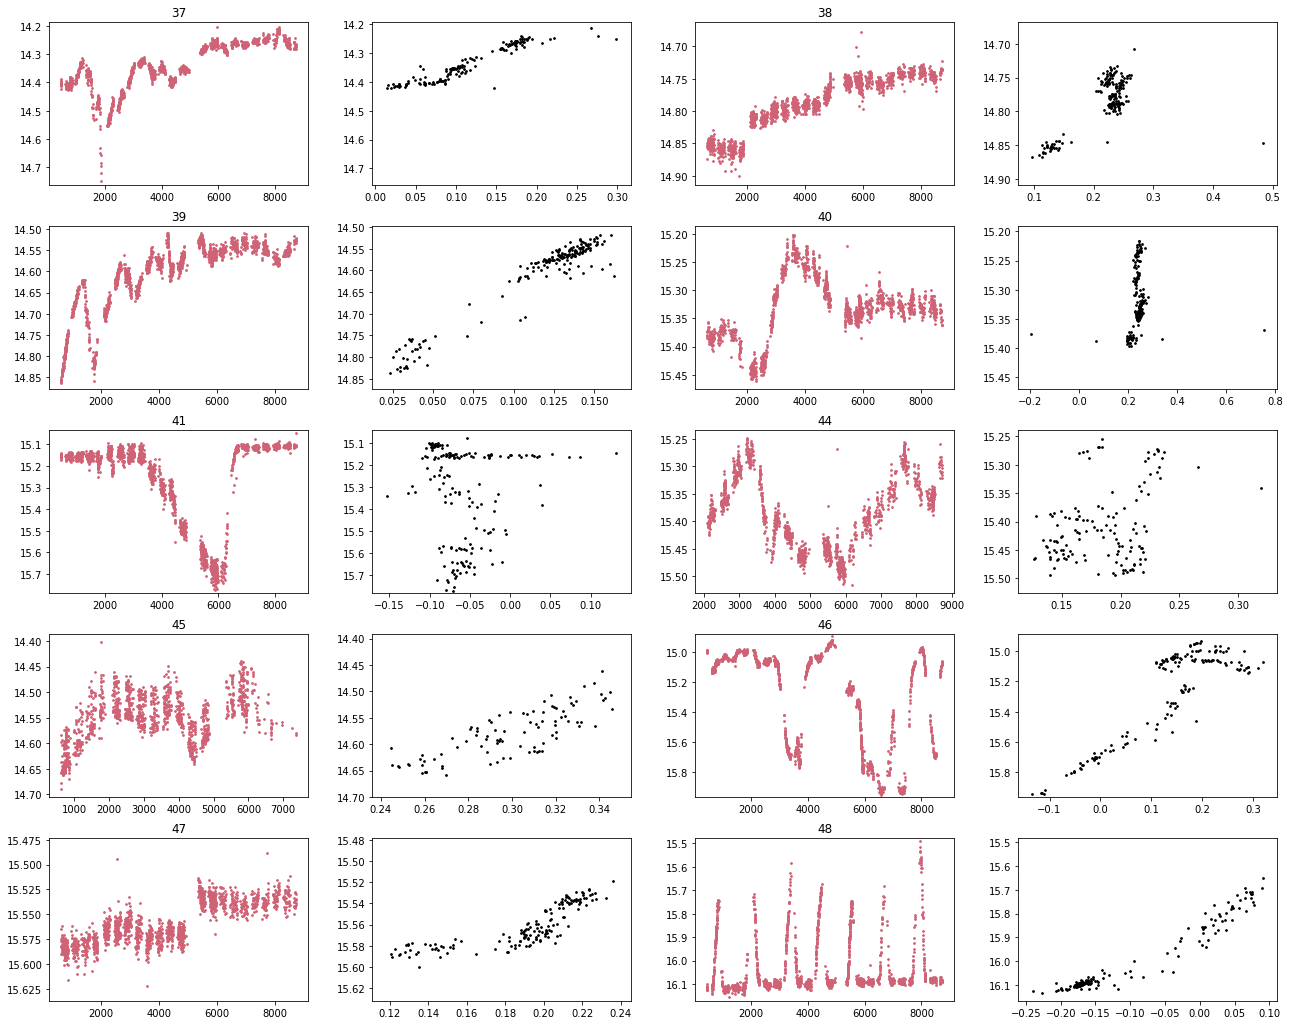

In [74]:
gallery(n=30)

In [75]:
len(cross)

58

keep in mind there's a source that it fails to read in ~43 because numbers read in as strings